In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Read data files
central = pd.read_excel('/Users/kazi0302/Desktop/SDSU/MSCSDS/COVID-19-Modeling-and-Parameter-Fitting/Data/Data-Processed-Date/Regions-By-Date.xlsx', header = None, sheet_name = 'Central Region (2)')
east = pd.read_excel('/Users/kazi0302/Desktop/SDSU/MSCSDS/COVID-19-Modeling-and-Parameter-Fitting/Data/Data-Processed-Date/Regions-By-Date.xlsx', header = None, sheet_name = 'East Region')
north_central = pd.read_excel('/Users/kazi0302/Desktop/SDSU/MSCSDS/COVID-19-Modeling-and-Parameter-Fitting/Data/Data-Processed-Date/Regions-By-Date.xlsx', header = None, sheet_name = 'North Central')
north_coastal = pd.read_excel('/Users/kazi0302/Desktop/SDSU/MSCSDS/COVID-19-Modeling-and-Parameter-Fitting/Data/Data-Processed-Date/Regions-By-Date.xlsx', header = None, sheet_name = 'North Costal')
north_inland = pd.read_excel('/Users/kazi0302/Desktop/SDSU/MSCSDS/COVID-19-Modeling-and-Parameter-Fitting/Data/Data-Processed-Date/Regions-By-Date.xlsx', header = None, sheet_name = 'North Inland')
south = pd.read_excel('/Users/kazi0302/Desktop/SDSU/MSCSDS/COVID-19-Modeling-and-Parameter-Fitting/Data/Data-Processed-Date/Regions-By-Date.xlsx', header = None, sheet_name = 'South Region')

# Set headers
central.columns = ['Case Count (Raw)', 'Total Rate (Suppressed)', 'Date', 'Diff']
east.columns = ['Case Count (Raw)', 'Total Rate (Suppressed)', 'Date', 'Diff']
north_central.columns = ['Case Count (Raw)', 'Total Rate (Suppressed)', 'Date', 'Diff']
north_coastal.columns = ['Case Count (Raw)', 'Total Rate (Suppressed)', 'Date', 'Diff']
north_inland.columns = ['Case Count (Raw)', 'Total Rate (Suppressed)', 'Date', 'Diff']
south.columns = ['Case Count (Raw)', 'Total Rate (Suppressed)', 'Date', 'Diff']

# Transform data to datetime format
central['Date'] = pd.to_datetime(central['Date'])
east['Date'] = pd.to_datetime(east['Date'])
north_central['Date'] = pd.to_datetime(north_central['Date'])
north_coastal['Date'] = pd.to_datetime(north_coastal['Date'])
north_inland['Date'] = pd.to_datetime(north_inland['Date'])
south['Date'] = pd.to_datetime(south['Date'])

In [3]:
df_count = pd.read_excel('/Users/kazi0302/Desktop/SDSU/MSCSDS/COVID-19-Modeling-and-Parameter-Fitting/Data/MobilityData.xlsx', sheet_name='sod_od_hhsa')

df_count = df_count[:10253]
df_count.drop(['hhsa_orig', 'hhsa_dest'], axis=1, inplace=True)

for i in range(len(df_count)):
    if df_count['hhsa_name_orig'][i] != df_count['hhsa_name_dest'][i]:
        df_count.drop(i, inplace=True)

# Reset index
df_count.reset_index(drop=True, inplace=True)

df_count_copy = df_count.copy()

for i in range(len(df_count_copy)):
    if df_count_copy['date_start'][i] < pd.Timestamp(2020, 4, 3, 0):
        df_count_copy.drop(i, inplace=True)

# Reset index
df_count_copy.reset_index(drop=True, inplace=True)

central_total_temp = []
east_total_temp = []
north_central_total_temp = []
north_coastal_total_temp = []
north_inland_total_temp = []
south_total_temp = []

for i in range(len(df_count_copy)):
    if df_count_copy['hhsa_name_orig'][i] == 'CENTRAL' == df_count_copy['hhsa_name_dest'][i]:
        central_total_temp.append(df_count_copy['dev_count'][i])
    elif df_count_copy['hhsa_name_orig'][i] == 'EAST' == df_count_copy['hhsa_name_dest'][i]:
        east_total_temp.append(df_count_copy['dev_count'][i])
    elif df_count_copy['hhsa_name_orig'][i] == 'NORTH CENTRAL' == df_count_copy['hhsa_name_dest'][i]:
        north_central_total_temp.append(df_count_copy['dev_count'][i])
    elif df_count_copy['hhsa_name_orig'][i] == 'NORTH COASTAL' == df_count_copy['hhsa_name_dest'][i]:
        north_coastal_total_temp.append(df_count_copy['dev_count'][i])
    elif df_count_copy['hhsa_name_orig'][i] == 'NORTH INLAND' == df_count_copy['hhsa_name_dest'][i]:
        north_inland_total_temp.append(df_count_copy['dev_count'][i])
    elif df_count_copy['hhsa_name_orig'][i] == 'SOUTH' == df_count_copy['hhsa_name_dest'][i]:
        south_total_temp.append(df_count_copy['dev_count'][i])

In [4]:
# Susceptible, Exposed, Infected_Symptomatic, Infected_Asymptomatic, Recovered
init_pop = {
    'Central_High': [234144, 1, 1, 1, 0], # assuming the 1st E, I, A begin from Central region
    'Central_Low': [277516, 0, 0, 0, 0],
    'East_High': [249102, 0, 0, 0, 0],
    'East_Low': [239228, 0, 0, 0, 0],
    'North_Central_High': [175301, 0, 0, 0, 0],
    'North_Central_Low': [471079, 0, 0, 0, 0],
    'North_Coastal_High': [159507, 0, 0, 0, 0],
    'North_Coastal_Low': [375712, 0, 0, 0, 0],
    'North_Inland_High': [195235, 0, 0, 0, 0],
    'North_Inland_Low': [406765, 0, 0, 0, 0],
    'South_High': [212538, 0, 0, 0, 0],
    'South_Low': [287538, 0, 0, 0, 0]
}

In [5]:
# Extracting the initial conditions from above

# Central High Risk
S_H_C_0, E_H_C_0, I_H_C_0, A_H_C_0, R_H_C_0 = init_pop['Central_High'][0],\
                                    init_pop['Central_High'][1],\
                                    init_pop['Central_High'][2],\
                                    init_pop['Central_High'][3],\
                                    init_pop['Central_High'][4]

# Central Low Risk
S_L_C_0, E_L_C_0, I_L_C_0, A_L_C_0, R_L_C_0 = init_pop['Central_Low'][0],\
                                    init_pop['Central_Low'][1],\
                                    init_pop['Central_Low'][2],\
                                    init_pop['Central_Low'][3],\
                                    init_pop['Central_Low'][4]

# East High Risk
S_H_E_0, E_H_E_0, I_H_E_0, A_H_E_0, R_H_E_0 = init_pop['East_High'][0],\
                                    init_pop['East_High'][1],\
                                    init_pop['East_High'][2],\
                                    init_pop['East_High'][3],\
                                    init_pop['East_High'][4]

# East Low Risk
S_L_E_0, E_L_E_0, I_L_E_0, A_L_E_0, R_L_E_0 = init_pop['East_Low'][0],\
                                    init_pop['East_Low'][1],\
                                    init_pop['East_Low'][2],\
                                    init_pop['East_Low'][3],\
                                    init_pop['East_Low'][4]

# North Central High Risk
S_H_NCen_0, E_H_NCen_0, I_H_NCen_0, A_H_NCen_0, R_H_NCen_0 = init_pop['North_Central_High'][0],\
                                                   init_pop['North_Central_High'][1],\
                                                   init_pop['North_Central_High'][2],\
                                                   init_pop['North_Central_High'][3],\
                                                   init_pop['North_Central_High'][4]

# North Central Low Risk
S_L_NCen_0, E_L_NCen_0, I_L_NCen_0, A_L_NCen_0, R_L_NCen_0 =  init_pop['North_Central_Low'][0],\
                                                    init_pop['North_Central_Low'][1],\
                                                    init_pop['North_Central_Low'][2],\
                                                    init_pop['North_Central_Low'][3],\
                                                    init_pop['North_Central_Low'][4]

# North Coastal High Risk
S_H_NCoa_0, E_H_NCoa_0, I_H_NCoa_0, A_H_NCoa_0, R_H_NCoa_0 =  init_pop['North_Coastal_High'][0],\
                                                    init_pop['North_Coastal_High'][1],\
                                                    init_pop['North_Coastal_High'][2],\
                                                    init_pop['North_Coastal_High'][3],\
                                                    init_pop['North_Coastal_High'][4]

# North Coastal Low Risk
S_L_NCoa_0, E_L_NCoa_0, I_L_NCoa_0, A_L_NCoa_0, R_L_NCoa_0 =  init_pop['North_Coastal_Low'][0],\
                                                    init_pop['North_Coastal_Low'][1],\
                                                    init_pop['North_Coastal_Low'][2],\
                                                    init_pop['North_Coastal_Low'][3],\
                                                    init_pop['North_Coastal_Low'][4]

# North Inland High Risk
S_H_NI_0, E_H_NI_0, I_H_NI_0, A_H_NI_0, R_H_NI_0 =  init_pop['North_Inland_High'][0],\
                                          init_pop['North_Inland_High'][1],\
                                          init_pop['North_Inland_High'][2],\
                                          init_pop['North_Inland_High'][3],\
                                          init_pop['North_Inland_High'][4]

# North Inland Low Risk
S_L_NI_0, E_L_NI_0, I_L_NI_0, A_L_NI_0, R_L_NI_0 =  init_pop['North_Inland_Low'][1],\
                                          init_pop['North_Inland_Low'][1],\
                                          init_pop['North_Inland_Low'][2],\
                                          init_pop['North_Inland_Low'][3],\
                                          init_pop['North_Inland_Low'][4]

# South High Risk
S_H_S_0, E_H_S_0, I_H_S_0, A_H_S_0, R_H_S_0 = init_pop['South_High'][0],\
                                    init_pop['South_High'][1],\
                                    init_pop['South_High'][2],\
                                    init_pop['South_High'][3],\
                                    init_pop['South_High'][4]

# South Low Risk
S_L_S_0, E_L_S_0, I_L_S_0, A_L_S_0, R_L_S_0 = init_pop['South_Low'][0],\
                                    init_pop['South_Low'][1],\
                                    init_pop['South_Low'][2],\
                                    init_pop['South_Low'][3],\
                                    init_pop['South_Low'][4]

### Function for Discrete Stochastic SEIAR Model

In [6]:
# Assumed parameters -> modified based on the situation
param_dict = {
    'High': [0.4e-6, 0.2e-6, 1/5, 0.4, 1/14, 0.001],
    'Low': [0.4e-6, 0.2e-6, 1/5, 0.4, 1/14, 0.001],
}

gamma = param_dict['High'][2] # 1/gamma = incubation period (per day)
theta = param_dict['High'][3] # theta = proportion of showing symptoms (sympomatic rate) (per day)
lamb = param_dict['High'][4] # 1/lambda = infectious period (per day)
delta = param_dict['High'][5] # death rate (per day)

In [7]:
def SEIAR_model(S_H_C_init, E_H_C_init, I_H_C_init, A_H_C_init, R_H_C_init, S_L_C_init, E_L_C_init, I_L_C_init, A_L_C_init, R_L_C_init,\
               S_H_E_init, E_H_E_init, I_H_E_init, A_H_E_init, R_H_E_init, S_L_E_init, E_L_E_init, I_L_E_init, A_L_E_init, R_L_E_init,\
               S_H_NCen_init, E_H_NCen_init, I_H_NCen_init, A_H_NCen_init, R_H_NCen_init, S_L_NCen_init, E_L_NCen_init, I_L_NCen_init, A_L_NCen_init, R_L_NCen_init,\
               S_H_NCoa_init, E_H_NCoa_init, I_H_NCoa_init, A_H_NCoa_init, R_H_NCoa_init, S_L_NCoa_init, E_L_NCoa_init, I_L_NCoa_init, A_L_NCoa_init, R_L_NCoa_init,\
               S_H_NI_init, E_H_NI_init, I_H_NI_init, A_H_NI_init, R_H_NI_init, S_L_NI_init, E_L_NI_init, I_L_NI_init, A_L_NI_init, R_L_NI_init,\
               S_H_S_init, E_H_S_init, I_H_S_init, A_H_S_init, R_H_S_init, S_L_S_init, E_L_S_init, I_L_S_init, A_L_S_init, R_L_S_init, \
               beta_sym, beta_asym, gamma, theta, lamb, delta):
   
    '''
    Use the SEIAR model to predict the number of people in each compartment at each time step.
    The MC simulation estimates the mean of the number of people in each compartment at each time step.
    ------------------------------------------------------------------------------------------
    Input:
        Initial population in each compartment (line 1-6)
        beta_sym: transmission rate of symptomatic individuals -> to be calibrated
        beta_asym: transmission rate of asymptomatic individuals -> to be calibrated
        gamma: rate of recovery
        theta: rate of progression from exposed to infectious
        lamb: rate of progression from infectious to asymptomatic
        delta: rate of progression from asymptomatic to recovered
    
    Output:
        Populations for SEIAR from each region
    '''

    # Simulation length (in days)
    t = 151
    
    # Initialise arrays to store populations
    C_H = np.zeros((t+1, 5))
    C_L = np.zeros((t+1, 5))

    E_H = np.zeros((t+1, 5))
    E_L = np.zeros((t+1, 5))

    NCen_H = np.zeros((t+1, 5))
    NCen_L = np.zeros((t+1, 5))

    NCoa_H = np.zeros((t+1, 5))
    NCoa_L = np.zeros((t+1, 5))

    NI_H = np.zeros((t+1, 5))
    NI_L = np.zeros((t+1, 5))

    S_H = np.zeros((t+1, 5))
    S_L = np.zeros((t+1, 5))

    # Initial Conditions
    C_H[0][0], C_H[0][1], C_H[0][2], C_H[0][3], C_H[0][4] = S_H_C_init, E_H_C_init, I_H_C_init, A_H_C_init, R_H_C_init
    C_L[0][0], C_L[0][1], C_L[0][2], C_L[0][3], C_L[0][4] = S_L_C_init, E_L_C_init, I_L_C_init, A_L_C_init, R_L_C_init

    E_H[0][0], E_H[0][1], E_H[0][2], E_H[0][3], E_H[0][4] = S_H_E_init, E_H_E_init, I_H_E_init, A_H_E_init, R_H_E_init
    E_L[0][0], E_L[0][1], E_L[0][2], E_L[0][3], E_L[0][4] = S_L_E_init, E_L_E_init, I_L_E_init, A_L_E_init, R_L_E_init

    NCen_H[0][0], NCen_H[0][1], NCen_H[0][2], NCen_H[0][3], NCen_H[0][4] = S_H_NCen_init, E_H_NCen_init, I_H_NCen_init, A_H_NCen_init, R_H_NCen_init
    NCen_L[0][0], NCen_L[0][1], NCen_L[0][2], NCen_L[0][3], NCen_L[0][4] = S_L_NCen_init, E_L_NCen_init, I_L_NCen_init, A_L_NCen_init, R_L_NCen_init

    NCoa_H[0][0], NCoa_H[0][1], NCoa_H[0][2], NCoa_H[0][3], NCoa_H[0][4] = S_H_NCoa_init, E_H_NCoa_init, I_H_NCoa_init, A_H_NCoa_init, R_H_NCoa_init
    NCoa_L[0][0], NCoa_L[0][1], NCoa_L[0][2], NCoa_L[0][3], NCoa_L[0][4] = S_L_NCoa_init, E_L_NCoa_init, I_L_NCoa_init, A_L_NCoa_init, R_L_NCoa_init

    NI_H[0][0], NI_H[0][1], NI_H[0][2], NI_H[0][3], NI_H[0][4] = S_H_NI_init, E_H_NI_init, I_H_NI_init, A_H_NI_init, R_H_NI_init
    NI_L[0][0], NI_L[0][1], NI_L[0][2], NI_L[0][3], NI_L[0][4] = S_L_NI_init, E_L_NI_init, I_L_NI_init, A_L_NI_init, R_L_NI_init

    S_H[0][0], S_H[0][1], S_H[0][2], S_H[0][3], S_H[0][4] = S_H_S_init, E_H_S_init, I_H_S_init, A_H_S_init, R_H_S_init
    S_L[0][0], S_L[0][1], S_L[0][2], S_L[0][3], S_L[0][4] = S_L_S_init, E_L_S_init, I_L_S_init, A_L_S_init, R_L_S_init

    # Initialise populations
    S_H_C, E_H_C, I_H_C, A_H_C, R_H_C = S_H_C_init, E_H_C_init, I_H_C_init, A_H_C_init, R_H_C_init
    S_L_C, E_L_C, I_L_C, A_L_C, R_L_C = S_L_C_init, E_L_C_init, I_L_C_init, A_L_C_init, R_L_C_init

    S_H_E, E_H_E, I_H_E, A_H_E, R_H_E = S_H_E_init, E_H_E_init, I_H_E_init, A_H_E_init, R_H_E_init
    S_L_E, E_L_E, I_L_E, A_L_E, R_L_E = S_L_E_init, E_L_E_init, I_L_E_init, A_L_E_init, R_L_E_init

    S_H_NCen, E_H_NCen, I_H_NCen, A_H_NCen, R_H_NCen = S_H_NCen_init, E_H_NCen_init, I_H_NCen_init, A_H_NCen_init, R_H_NCen_init
    S_L_NCen, E_L_NCen, I_L_NCen, A_L_NCen, R_L_NCen = S_L_NCen_init, E_L_NCen_init, I_L_NCen_init, A_L_NCen_init, R_L_NCen_init

    S_H_NCoa, E_H_NCoa, I_H_NCoa, A_H_NCoa, R_H_NCoa = S_H_NCoa_init, E_H_NCoa_init, I_H_NCoa_init, A_H_NCoa_init, R_H_NCoa_init
    S_L_NCoa, E_L_NCoa, I_L_NCoa, A_L_NCoa, R_L_NCoa = S_L_NCoa_init, E_L_NCoa_init, I_L_NCoa_init, A_L_NCoa_init, R_L_NCoa_init

    S_H_NI, E_H_NI, I_H_NI, A_H_NI, R_H_NI = S_H_NI_init, E_H_NI_init, I_H_NI_init, A_H_NI_init, R_H_NI_init
    S_L_NI, E_L_NI, I_L_NI, A_L_NI, R_L_NI = S_L_NI_init, E_L_NI_init, I_L_NI_init, A_L_NI_init, R_L_NI_init

    S_H_S, E_H_S, I_H_S, A_H_S, R_H_S = S_H_S_init, E_H_S_init, I_H_S_init, A_H_S_init, R_H_S_init
    S_L_S, E_L_S, I_L_S, A_L_S, R_L_S = S_L_S_init, E_L_S_init, I_L_S_init, A_L_S_init, R_L_S_init


    mob_central_dict = {

        'East': [2518.007912, 1179.226414, 2302.018371], \
        'North_Central': [5431.723516, 1940.995073, 4336.156366], \
        'North_Coastal': [410.088803, 224.745859, 654.88667], \
        'North_Inland': [664.540636, 366.97859, 588.297201], \
        'South': [3640.640873, 1626.007515, 2917.389471]

    }

    mob_east_dict = {

        'Central': [3768.837284, 1440.608412, 2866.137454], \
        'North_Central': [5425.003638, 1919.445416, 4670.294659], \
        'North_Coastal': [483.573126, 191.392576, 473.906442], \
        'North_Inland': [1055.682996, 484.299215, 842.685923], \
        'South': [2488.03862, 980.052445, 2087.730478]

    }

    mob_north_central_dict = {

        'Central': [3657.897354, 1054.592602, 3087.41847], \
        'East': [2111.999373, 871.361025, 2093.514868], \
        'North_Coastal': [1656.53273, 460.539775, 1724.08199], \
        'North_Inland': [2767.349274, 983.942653, 2341.094009], \
        'South': [1257.405478, 596.794501, 1182.745383]

    }

    mob_north_coastal_dict = {

        'Central': [780.166594, 156.644603, 1196.23607], \
        'East': [246.915804, 115.929512, 226.261725], \
        'North_Central': [2547.496323, 631.995693, 1936.045114], \
        'North_Inland': [3898.342286, 1414.099677, 3053.434645], \
        'South': [258.826212, 133.157868, 306.770863]

    }

    mob_north_inland_dict = {

        'Central': [1507.037202, 392.630209, 1305.236506], \
        'East': [1000.642647, 390.292827, 879.488701], \
        'North_Central': [6136.233626, 1687.503238, 4745.989662], \
        'North_Coastal': [5256.002028, 1827.728619, 4981.44469], \
        'South': [607.446061, 255.851188, 534.272639]

    }

    mob_south_dict = {

        'Central': [4053.532554, 1545.91116, 2984.388535], \
        'East': [1970.762799, 828.927306, 1716.573243], \
        'North_Central': [3883.18689, 1374.748533, 3361.535465], \
        'North_Coastal': [391.417326, 147.78653, 331.027812], \
        'North_Inland': [622.229053, 262.674827, 511.746844]

    }

    central_total = central_total_temp
    east_total = east_total_temp
    north_central_total = north_central_total_temp
    north_coastal_total = north_coastal_total_temp
    north_inland_total = north_inland_total_temp
    south_total = south_total_temp


    # Mobility changes for 3 phases -> refer to ./Data/Mobility.ipynb
    for day in range(1, t+1):

        if day <= 70:
            
            # Retrieve mobility changes for each region
            mob_central_east = mob_central_dict['East'][0] / central_total[day-1]
            mob_central_north_central = mob_central_dict['North_Central'][0] / central_total[day-1]
            mob_central_north_coastal = mob_central_dict['North_Coastal'][0] / central_total[day-1]
            mob_central_north_inland = mob_central_dict['North_Inland'][0] / central_total[day-1]
            mob_central_south = mob_central_dict['South'][0] / central_total[day-1]

            mob_east_central = mob_east_dict['Central'][0] / east_total[day-1]
            mob_east_north_central = mob_east_dict['North_Central'][0] / east_total[day-1]
            mob_east_north_coastal = mob_east_dict['North_Coastal'][0] / east_total[day-1]
            mob_east_north_inland = mob_east_dict['North_Inland'][0] / east_total[day-1]
            mob_east_south = mob_east_dict['South'][0] / east_total[day-1]

            mob_north_central_central = mob_north_central_dict['Central'][0] / north_central_total[day-1]
            mob_north_central_east = mob_north_central_dict['East'][0] / north_central_total[day-1]
            mob_north_central_north_coastal = mob_north_central_dict['North_Coastal'][0] / north_central_total[day-1]
            mob_north_central_north_inland = mob_north_central_dict['North_Inland'][0] / north_central_total[day-1]
            mob_north_central_south = mob_north_central_dict['South'][0] / north_central_total[day-1]

            mob_north_coastal_central = mob_north_coastal_dict['Central'][0] / north_coastal_total[day-1]
            mob_north_coastal_east = mob_north_coastal_dict['East'][0] / north_coastal_total[day-1]
            mob_north_coastal_north_central = mob_north_coastal_dict['North_Central'][0] / north_coastal_total[day-1]
            mob_north_coastal_north_inland = mob_north_coastal_dict['North_Inland'][0] / north_coastal_total[day-1]
            mob_north_coastal_south = mob_north_coastal_dict['South'][0] / north_coastal_total[day-1]

            mob_north_inland_central = mob_north_inland_dict['Central'][0] / north_inland_total[day-1]
            mob_north_inland_east = mob_north_inland_dict['East'][0] / north_inland_total[day-1]
            mob_north_inland_north_central = mob_north_inland_dict['North_Central'][0] / north_inland_total[day-1]
            mob_north_inland_north_coastal = mob_north_inland_dict['North_Coastal'][0] / north_inland_total[day-1]
            mob_north_inland_south = mob_north_inland_dict['South'][0] / north_inland_total[day-1]

            mob_south_central = mob_south_dict['Central'][0] / south_total[day-1]
            mob_south_east = mob_south_dict['East'][0] / south_total[day-1]
            mob_south_north_central = mob_south_dict['North_Central'][0] / south_total[day-1]
            mob_south_north_coastal = mob_south_dict['North_Coastal'][0] / south_total[day-1]
            mob_south_north_inland = mob_south_dict['North_Inland'][0] / south_total[day-1]
           
        elif day > 70 and day <= 80:

            # Same as above
            mob_central_east = mob_central_dict['East'][1] / central_total[day-1]
            mob_central_north_central = mob_central_dict['North_Central'][1] / central_total[day-1]
            mob_central_north_coastal = mob_central_dict['North_Coastal'][1] / central_total[day-1]
            mob_central_north_inland = mob_central_dict['North_Inland'][1] / central_total[day-1]
            mob_central_south = mob_central_dict['South'][1] / central_total[day-1]

            mob_east_central = mob_east_dict['Central'][1] / east_total[day-1]
            mob_east_north_central = mob_east_dict['North_Central'][1] / east_total[day-1]
            mob_east_north_coastal = mob_east_dict['North_Coastal'][1] / east_total[day-1]
            mob_east_north_inland = mob_east_dict['North_Inland'][1] / east_total[day-1]
            mob_east_south = mob_east_dict['South'][1] / east_total[day-1]

            mob_north_central_central = mob_north_central_dict['Central'][1] / north_central_total[day-1]
            mob_north_central_east = mob_north_central_dict['East'][1] / north_central_total[day-1]
            mob_north_central_north_coastal = mob_north_central_dict['North_Coastal'][1] / north_central_total[day-1]
            mob_north_central_north_inland = mob_north_central_dict['North_Inland'][1] / north_central_total[day-1]
            mob_north_central_south = mob_north_central_dict['South'][1] / north_central_total[day-1]

            mob_north_coastal_central = mob_north_coastal_dict['Central'][1] / north_coastal_total[day-1]
            mob_north_coastal_east = mob_north_coastal_dict['East'][1] / north_coastal_total[day-1]
            mob_north_coastal_north_central = mob_north_coastal_dict['North_Central'][1] / north_coastal_total[day-1]
            mob_north_coastal_north_inland = mob_north_coastal_dict['North_Inland'][1] / north_coastal_total[day-1]
            mob_north_coastal_south = mob_north_coastal_dict['South'][1] / north_coastal_total[day-1]

            mob_north_inland_central = mob_north_inland_dict['Central'][1] / north_inland_total[day-1]
            mob_north_inland_east = mob_north_inland_dict['East'][1] / north_inland_total[day-1]
            mob_north_inland_north_central = mob_north_inland_dict['North_Central'][1] / north_inland_total[day-1]
            mob_north_inland_north_coastal = mob_north_inland_dict['North_Coastal'][1] / north_inland_total[day-1]
            mob_north_inland_south = mob_north_inland_dict['South'][1] / north_inland_total[day-1]

            mob_south_central = mob_south_dict['Central'][1] / south_total[day-1]
            mob_south_east = mob_south_dict['East'][1] / south_total[day-1]
            mob_south_north_central = mob_south_dict['North_Central'][1] / south_total[day-1]
            mob_south_north_coastal = mob_south_dict['North_Coastal'][1] / south_total[day-1]
            mob_south_north_inland = mob_south_dict['North_Inland'][1] / south_total[day-1]

        else:

            # Same as above
            mob_central_east = mob_central_dict['East'][2] / central_total[day-1]
            mob_central_north_central = mob_central_dict['North_Central'][2] / central_total[day-1]
            mob_central_north_coastal = mob_central_dict['North_Coastal'][2] / central_total[day-1]
            mob_central_north_inland = mob_central_dict['North_Inland'][2] / central_total[day-1]
            mob_central_south = mob_central_dict['South'][2] / central_total[day-1]

            mob_east_central = mob_east_dict['Central'][2] / east_total[day-1]
            mob_east_north_central = mob_east_dict['North_Central'][2] / east_total[day-1]
            mob_east_north_coastal = mob_east_dict['North_Coastal'][2] / east_total[day-1]
            mob_east_north_inland = mob_east_dict['North_Inland'][2] / east_total[day-1]
            mob_east_south = mob_east_dict['South'][2] / east_total[day-1]

            mob_north_central_central = mob_north_central_dict['Central'][2] / north_central_total[day-1]
            mob_north_central_east = mob_north_central_dict['East'][2] / north_central_total[day-1]
            mob_north_central_north_coastal = mob_north_central_dict['North_Coastal'][2] / north_central_total[day-1]
            mob_north_central_north_inland = mob_north_central_dict['North_Inland'][2] / north_central_total[day-1]
            mob_north_central_south = mob_north_central_dict['South'][2] / north_central_total[day-1]

            mob_north_coastal_central = mob_north_coastal_dict['Central'][2] / north_coastal_total[day-1]
            mob_north_coastal_east = mob_north_coastal_dict['East'][2] / north_coastal_total[day-1]
            mob_north_coastal_north_central = mob_north_coastal_dict['North_Central'][2] / north_coastal_total[day-1]
            mob_north_coastal_north_inland = mob_north_coastal_dict['North_Inland'][2] / north_coastal_total[day-1]
            mob_north_coastal_south = mob_north_coastal_dict['South'][2] / north_coastal_total[day-1]

            mob_north_inland_central = mob_north_inland_dict['Central'][2] / north_inland_total[day-1]
            mob_north_inland_east = mob_north_inland_dict['East'][2] / north_inland_total[day-1]
            mob_north_inland_north_central = mob_north_inland_dict['North_Central'][2] / north_inland_total[day-1]
            mob_north_inland_north_coastal = mob_north_inland_dict['North_Coastal'][2] / north_inland_total[day-1]
            mob_north_inland_south = mob_north_inland_dict['South'][2] / north_inland_total[day-1]

            mob_south_central = mob_south_dict['Central'][2] / south_total[day-1]
            mob_south_east = mob_south_dict['East'][2] / south_total[day-1]
            mob_south_north_central = mob_south_dict['North_Central'][2] / south_total[day-1]
            mob_south_north_coastal = mob_south_dict['North_Coastal'][2] / south_total[day-1]
            mob_south_north_inland = mob_south_dict['North_Inland'][2] / south_total[day-1]

        
        # Compute Monte Carlo simulation using biniomial distribution
        # n = initial population, p = probability of event from the model
        Central_High = {'S_to_E': np.random.binomial(S_H_C, (beta_sym * (I_H_C + I_L_C)) + (beta_asym * (A_H_C + A_L_C))),
                        'E_to_I': np.random.binomial(E_H_C, gamma*theta),
                        'E_to_A': np.random.binomial(E_H_C, gamma*(1-theta)),
                        'I_to_R': np.random.binomial(I_H_C, delta + lamb),
                        'A_to_R': np.random.binomial(A_H_C, delta) }

        Central_Low = { 'S_to_E': np.random.binomial(S_L_C, (beta_sym * (I_H_C + I_L_C)) + (beta_asym * (A_H_C + A_L_C))),
                        'E_to_I': np.random.binomial(E_L_C, gamma*theta),
                        'E_to_A': np.random.binomial(E_L_C, gamma*(1-theta)),
                        'I_to_R': np.random.binomial(I_L_C, delta + lamb),
                        'A_to_R': np.random.binomial(A_L_C, delta) }

        East_High = { 'S_to_E': np.random.binomial(S_H_E, (beta_sym * (I_H_E + I_L_E)) + (beta_asym * (A_H_E + A_L_E))),
                      'E_to_I': np.random.binomial(E_H_E, gamma*theta),
                      'E_to_A': np.random.binomial(E_H_E, gamma*(1-theta)),
                      'I_to_R': np.random.binomial(I_H_E, delta + lamb),
                      'A_to_R': np.random.binomial(A_H_E, delta) }

        East_Low = {    'S_to_E': np.random.binomial(S_L_E, (beta_sym * (I_H_E + I_L_E)) + (beta_asym * (A_H_E + A_L_E))),
                        'E_to_I': np.random.binomial(E_L_E, gamma*theta),
                        'E_to_A': np.random.binomial(E_L_E, gamma*(1-theta)),
                        'I_to_R': np.random.binomial(I_L_E, delta + lamb),
                        'A_to_R': np.random.binomial(A_L_E, delta) }
        
        North_Central_High = {  'S_to_E': np.random.binomial(S_H_NCen, (beta_sym * (I_H_NCen + I_L_NCen)) + (beta_asym * (A_H_NCen + A_L_NCen))),
                                'E_to_I': np.random.binomial(E_H_NCen, gamma*theta),
                                'E_to_A': np.random.binomial(E_H_NCen, gamma*(1-theta)),
                                'I_to_R': np.random.binomial(I_H_NCen, delta + lamb),
                                'A_to_R': np.random.binomial(A_H_NCen, delta) }
        
        North_Central_Low = {   'S_to_E': np.random.binomial(S_L_NCen, (beta_sym * (I_H_NCen + I_L_NCen) + (beta_asym * (A_H_NCen + A_L_NCen)))),
                                'E_to_I': np.random.binomial(E_L_NCen, gamma*theta),
                                'E_to_A': np.random.binomial(E_L_NCen, gamma*(1-theta)),
                                'I_to_R': np.random.binomial(I_L_NCen, delta + lamb),
                                'A_to_R': np.random.binomial(A_L_NCen, delta) }

        North_Coastal_High = {  'S_to_E': np.random.binomial(S_H_NCoa, (beta_sym * (I_H_NCoa + I_L_NCoa)) + (beta_asym * (A_H_NCoa + A_L_NCoa))),
                                'E_to_I': np.random.binomial(E_H_NCoa, gamma*theta),
                                'E_to_A': np.random.binomial(E_H_NCoa, gamma*(1-theta)),
                                'I_to_R': np.random.binomial(I_H_NCoa, delta + lamb),
                                'A_to_R': np.random.binomial(A_H_NCoa, delta) }
        
        North_Coastal_Low = {   'S_to_E': np.random.binomial(S_L_NCoa, (beta_sym * (I_H_NCoa + I_L_NCoa)) + (beta_asym * (A_H_NCoa + A_L_NCoa))),
                                'E_to_I': np.random.binomial(E_L_NCoa, gamma*theta),
                                'E_to_A': np.random.binomial(E_L_NCoa, gamma*(1-theta)),
                                'I_to_R': np.random.binomial(I_L_NCoa, delta + lamb),
                                'A_to_R': np.random.binomial(A_L_NCoa, delta) }
        
        North_Inland_High = {   'S_to_E': np.random.binomial(S_H_NI, (beta_sym * (I_H_NI + I_L_NI)) + (beta_asym * (A_H_NI + A_L_NI))),
                                'E_to_I': np.random.binomial(E_H_NI, gamma*theta),
                                'E_to_A': np.random.binomial(E_H_NI, gamma*(1-theta)),
                                'I_to_R': np.random.binomial(I_H_NI, delta + lamb),
                                'A_to_R': np.random.binomial(A_H_NI, delta) }

        North_Inland_Low = {    'S_to_E': np.random.binomial(S_L_NI, (beta_sym * (I_H_NI + I_L_NI)) + (beta_asym * (A_H_NI + A_L_NI))),
                                'E_to_I': np.random.binomial(E_L_NI, gamma*theta),
                                'E_to_A': np.random.binomial(E_L_NI, gamma*(1-theta)),
                                'I_to_R': np.random.binomial(I_L_NI, delta + lamb),
                                'A_to_R': np.random.binomial(A_L_NI, delta) }
        
        South_High = {  'S_to_E': np.random.binomial(S_H_S, (beta_sym * (I_H_S + I_L_S)) + (beta_asym * (A_H_S + A_L_S))),
                        'E_to_I': np.random.binomial(E_H_S, gamma*theta),
                        'E_to_A': np.random.binomial(E_H_S, gamma*(1-theta)),
                        'I_to_R': np.random.binomial(I_H_S, delta + lamb),
                        'A_to_R': np.random.binomial(A_H_S, delta) }

        South_Low = {   'S_to_E': np.random.binomial(S_L_S, (beta_sym * (I_H_S + I_L_S)) + (beta_asym * (A_H_S + A_L_S))),
                        'E_to_I': np.random.binomial(E_L_S, gamma*theta),
                        'E_to_A': np.random.binomial(E_L_S, gamma*(1-theta)),
                        'I_to_R': np.random.binomial(I_L_S, delta + lamb),
                        'A_to_R': np.random.binomial(A_L_S, delta) }
                                
        # Update populations for SEAIR
        # np.max is used to ensure that the population does not go negative
        Central_High_S_new = np.max(S_H_C - Central_High['S_to_E'] + \
            (mob_east_central*S_H_E) + (mob_north_central_central*S_H_NCen) + (mob_north_coastal_central*S_H_NCoa) + (mob_north_inland_central*S_H_NI) + (mob_south_central*S_H_S) - \
            ((mob_central_east + mob_central_north_central + mob_central_north_coastal + mob_central_north_inland + mob_central_south)* S_H_C), \
            0)
        Central_High_E_new = np.max(E_H_C + Central_High['S_to_E'] - Central_High['E_to_I'] - Central_High['E_to_A'] + \
            (mob_east_central*E_H_E) + (mob_north_central_central*E_H_NCen) + (mob_north_coastal_central*E_H_NCoa) + (mob_north_inland_central*E_H_NI) + (mob_south_central*E_H_S) - \
            ((mob_central_east + mob_central_north_central + mob_central_north_coastal + mob_central_north_inland + mob_central_south)* E_H_C), \
            0)
        Central_High_I_new = np.max(I_H_C + Central_High['E_to_I'] - Central_High['I_to_R'] + \
            (mob_east_central*I_H_E) + (mob_north_central_central*I_H_NCen) + (mob_north_coastal_central*I_H_NCoa) + (mob_north_inland_central*I_H_NI) + (mob_south_central*I_H_S) - \
            ((mob_central_east + mob_central_north_central + mob_central_north_coastal + mob_central_north_inland + mob_central_south)* I_H_C), \
            0)
        Central_High_A_new = np.max(A_H_C + Central_High['E_to_A'] - Central_High['A_to_R'] + \
            (mob_east_central*A_H_E) + (mob_north_central_central*A_H_NCen) + (mob_north_coastal_central*A_H_NCoa) + (mob_north_inland_central*A_H_NI) + (mob_south_central*A_H_S) - \
            ((mob_central_east + mob_central_north_central + mob_central_north_coastal + mob_central_north_inland + mob_central_south)* A_H_C), \
            0)
        Central_High_R_new = np.max(R_H_C + Central_High['I_to_R'] + Central_High['A_to_R'] + \
            (mob_east_central*R_H_E) + (mob_north_central_central*R_H_NCen) + (mob_north_coastal_central*R_H_NCoa) + (mob_north_inland_central*R_H_NI) + (mob_south_central*R_H_S) - \
            ((mob_central_east + mob_central_north_central + mob_central_north_coastal + mob_central_north_inland + mob_central_south)* R_H_C), \
            0)

        Central_Low_S_new = np.max(S_L_C - Central_Low['S_to_E'] + \
            (mob_east_central*S_L_E) + (mob_north_central_central*S_L_NCen) + (mob_north_coastal_central*S_L_NCoa) + (mob_north_inland_central*S_L_NI) + (mob_south_central*S_L_S) - \
            ((mob_central_east + mob_central_north_central + mob_central_north_coastal + mob_central_north_inland + mob_central_south)* S_L_C), \
            0)
        Central_Low_E_new = np.max(E_L_C + Central_Low['S_to_E'] - Central_Low['E_to_I'] - Central_Low['E_to_A'] + \
            (mob_east_central*E_L_E) + (mob_north_central_central*E_L_NCen) + (mob_north_coastal_central*E_L_NCoa) + (mob_north_inland_central*E_L_NI) + (mob_south_central*E_L_S) - \
            ((mob_central_east + mob_central_north_central + mob_central_north_coastal + mob_central_north_inland + mob_central_south)* E_L_C), \
            0)
        Central_Low_I_new = np.max(I_L_C + Central_Low['E_to_I'] - Central_Low['I_to_R'] + \
            (mob_east_central*I_L_E) + (mob_north_central_central*I_L_NCen) + (mob_north_coastal_central*I_L_NCoa) + (mob_north_inland_central*I_L_NI) + (mob_south_central*I_L_S) - \
            ((mob_central_east + mob_central_north_central + mob_central_north_coastal + mob_central_north_inland + mob_central_south)* I_L_C), \
            0)
        Central_Low_A_new = np.max(A_L_C + Central_Low['E_to_A'] - Central_Low['A_to_R'] + \
            (mob_east_central*A_L_E) + (mob_north_central_central*A_L_NCen) + (mob_north_coastal_central*A_L_NCoa) + (mob_north_inland_central*A_L_NI) + (mob_south_central*A_L_S) - \
            ((mob_central_east + mob_central_north_central + mob_central_north_coastal + mob_central_north_inland + mob_central_south)* A_L_C), \
            0)
        Central_Low_R_new = np.max(R_L_C + Central_Low['I_to_R'] + Central_Low['A_to_R'] + \
            (mob_east_central*R_L_E) + (mob_north_central_central*R_L_NCen) + (mob_north_coastal_central*R_L_NCoa) + (mob_north_inland_central*R_L_NI) + (mob_south_central*R_L_S) - \
            ((mob_central_east + mob_central_north_central + mob_central_north_coastal + mob_central_north_inland + mob_central_south)* R_L_C), \
            0)
        
        East_High_S_new = np.max(S_H_E - East_High['S_to_E'] + \
            (mob_central_east*S_H_C) + (mob_north_central_east*S_H_NCen) + (mob_north_coastal_east*S_H_NCoa) + (mob_north_inland_east*S_H_NI) + (mob_south_east*S_H_S) - \
            ((mob_east_central + mob_east_north_central + mob_east_north_coastal + mob_east_north_inland + mob_east_south) * S_H_E), \
            0)
        East_High_E_new = np.max(E_H_E + East_High['S_to_E'] - East_High['E_to_I'] - East_High['E_to_A'] + \
            (mob_central_east*E_H_C) + (mob_north_central_east*E_H_NCen) + (mob_north_coastal_east*E_H_NCoa) + (mob_north_inland_east*E_H_NI) + (mob_south_east*E_H_S) - \
            ((mob_east_central + mob_east_north_central + mob_east_north_coastal + mob_east_north_inland + mob_east_south) * E_H_E), \
            0)
        East_High_I_new = np.max(I_H_E + East_High['E_to_I'] - East_High['I_to_R'] + \
            (mob_central_east*I_H_C) + (mob_north_central_east*I_H_NCen) + (mob_north_coastal_east*I_H_NCoa) + (mob_north_inland_east*I_H_NI) + (mob_south_east*I_H_S) - \
            ((mob_east_central + mob_east_north_central + mob_east_north_coastal + mob_east_north_inland + mob_east_south) * I_H_E), \
            0)
        East_High_A_new = np.max(A_H_E + East_High['E_to_A'] - East_High['A_to_R'] + \
            (mob_central_east*A_H_C) + (mob_north_central_east*A_H_NCen) + (mob_north_coastal_east*A_H_NCoa) + (mob_north_inland_east*A_H_NI) + (mob_south_east*A_H_S) - \
            ((mob_east_central + mob_east_north_central + mob_east_north_coastal + mob_east_north_inland + mob_east_south) * A_H_E), \
            0)
        East_High_R_new = np.max(R_H_E + East_High['I_to_R'] + East_High['A_to_R'] + \
            (mob_central_east*R_H_C) + (mob_north_central_east*R_H_NCen) + (mob_north_coastal_east*R_H_NCoa) + (mob_north_inland_east*R_H_NI) + (mob_south_east*R_H_S) - \
            ((mob_east_central + mob_east_north_central + mob_east_north_coastal + mob_east_north_inland + mob_east_south) * R_H_E), \
            0)

        East_Low_S_new = np.max(S_L_E - East_Low['S_to_E'] + \
            (mob_central_east*S_L_C) + (mob_north_central_east*S_L_NCen) + (mob_north_coastal_east*S_L_NCoa) + (mob_north_inland_east*S_L_NI) + (mob_south_east*S_L_S) - \
            ((mob_east_central + mob_east_north_central + mob_east_north_coastal + mob_east_north_inland + mob_east_south) * S_L_E), \
            0)
        East_Low_E_new = np.max(E_L_E + East_Low['S_to_E'] - East_Low['E_to_I'] - East_Low['E_to_A'] + \
            (mob_central_east*E_L_C) + (mob_north_central_east*E_L_NCen) + (mob_north_coastal_east*E_L_NCoa) + (mob_north_inland_east*E_L_NI) + (mob_south_east*E_L_S) - \
            ((mob_east_central + mob_east_north_central + mob_east_north_coastal + mob_east_north_inland + mob_east_south) * E_L_E), \
            0)
        East_Low_I_new = np.max(I_L_E + East_Low['E_to_I'] - East_Low['I_to_R'] + \
            (mob_central_east*I_L_C) + (mob_north_central_east*I_L_NCen) + (mob_north_coastal_east*I_L_NCoa) + (mob_north_inland_east*I_L_NI) + (mob_south_east*I_L_S) - \
            ((mob_east_central + mob_east_north_central + mob_east_north_coastal + mob_east_north_inland + mob_east_south) * I_L_E), \
            0)
        East_Low_A_new = np.max(A_L_E + East_Low['E_to_A'] - East_Low['A_to_R'] + \
            (mob_central_east*A_L_C) + (mob_north_central_east*A_L_NCen) + (mob_north_coastal_east*A_L_NCoa) + (mob_north_inland_east*A_L_NI) + (mob_south_east*A_L_S) - \
            ((mob_east_central + mob_east_north_central + mob_east_north_coastal + mob_east_north_inland + mob_east_south) * A_L_E), \
            0)
        East_Low_R_new = np.max(R_L_E + East_Low['I_to_R'] + East_Low['A_to_R'] + \
            (mob_central_east*R_L_C) + (mob_north_central_east*R_L_NCen) + (mob_north_coastal_east*R_L_NCoa) + (mob_north_inland_east*R_L_NI) + (mob_south_east*R_L_S) - \
            ((mob_east_central + mob_east_north_central + mob_east_north_coastal + mob_east_north_inland + mob_east_south) * R_L_E), \
            0)
        
        North_Central_High_S_new = np.max(S_H_NCen - North_Central_High['S_to_E'] + \
            (mob_central_north_central*S_H_C) + (mob_east_north_central*S_H_E) + (mob_north_coastal_north_central*S_H_NCoa) + (mob_north_inland_north_central*S_H_NI) + (mob_south_north_central*S_H_S) - \
            ((mob_north_central_central + mob_north_central_east + mob_north_central_north_coastal + mob_north_central_north_inland + mob_north_central_south) * S_H_NCen), \
            0)
        North_Central_High_E_new = np.max(E_H_NCen + North_Central_High['S_to_E'] - North_Central_High['E_to_I'] - North_Central_High['E_to_A'] + \
            (mob_central_north_central*E_H_C) + (mob_east_north_central*E_H_E) + (mob_north_coastal_north_central*E_H_NCoa) + (mob_north_inland_north_central*E_H_NI) + (mob_south_north_central*E_H_S) - \
            ((mob_north_central_central + mob_north_central_east + mob_north_central_north_coastal + mob_north_central_north_inland + mob_north_central_south) * E_H_NCen), \
            0)
        North_Central_High_I_new = np.max(I_H_NCen + North_Central_High['E_to_I'] - North_Central_High['I_to_R'] + \
            (mob_central_north_central*I_H_C) + (mob_east_north_central*I_H_E) + (mob_north_coastal_north_central*I_H_NCoa) + (mob_north_inland_north_central*I_H_NI) + (mob_south_north_central*I_H_S) - \
            ((mob_north_central_central + mob_north_central_east + mob_north_central_north_coastal + mob_north_central_north_inland + mob_north_central_south) * I_H_NCen), \
            0)
        North_Central_High_A_new = np.max(A_H_NCen + North_Central_High['E_to_A'] - North_Central_High['A_to_R'] + \
            (mob_central_north_central*A_H_C) + (mob_east_north_central*A_H_E) + (mob_north_coastal_north_central*A_H_NCoa) + (mob_north_inland_north_central*A_H_NI) + (mob_south_north_central*A_H_S) - \
            ((mob_north_central_central + mob_north_central_east + mob_north_central_north_coastal + mob_north_central_north_inland + mob_north_central_south) * A_H_NCen), \
            0)
        North_Central_High_R_new = np.max(R_H_NCen + North_Central_High['I_to_R'] + North_Central_High['A_to_R'] + \
            (mob_central_north_central*R_H_C) + (mob_east_north_central*R_H_E) + (mob_north_coastal_north_central*R_H_NCoa) + (mob_north_inland_north_central*R_H_NI) + (mob_south_north_central*R_H_S) - \
            ((mob_north_central_central + mob_north_central_east + mob_north_central_north_coastal + mob_north_central_north_inland + mob_north_central_south) * R_H_NCen), \
            0)

        North_Central_Low_S_new = np.max(S_L_NCen - North_Central_Low['S_to_E'] + \
            (mob_central_north_central*S_L_C) + (mob_east_north_central*S_L_E) + (mob_north_coastal_north_central*S_L_NCoa) + (mob_north_inland_north_central*S_L_NI) + (mob_south_north_central*S_L_S) - \
            ((mob_north_central_central + mob_north_central_east + mob_north_central_north_coastal + mob_north_central_north_inland + mob_north_central_south) * S_L_NCen), \
            0)
        North_Central_Low_E_new = np.max(E_L_NCen + North_Central_Low['S_to_E'] - North_Central_Low['E_to_I'] - North_Central_Low['E_to_A'] + \
            (mob_central_north_central*E_L_C) + (mob_east_north_central*E_L_E) + (mob_north_coastal_north_central*E_L_NCoa) + (mob_north_inland_north_central*E_L_NI) + (mob_south_north_central*E_L_S) - \
            ((mob_north_central_central + mob_north_central_east + mob_north_central_north_coastal + mob_north_central_north_inland + mob_north_central_south) * E_L_NCen), \
            0)
        North_Central_Low_I_new = np.max(I_L_NCen + North_Central_Low['E_to_I'] - North_Central_Low['I_to_R'] + \
            (mob_central_north_central*I_L_C) + (mob_east_north_central*I_L_E) + (mob_north_coastal_north_central*I_L_NCoa) + (mob_north_inland_north_central*I_L_NI) + (mob_south_north_central*I_L_S) - \
            ((mob_north_central_central + mob_north_central_east + mob_north_central_north_coastal + mob_north_central_north_inland + mob_north_central_south) * I_L_NCen), \
            0)
        North_Central_Low_A_new = np.max(A_L_NCen + North_Central_Low['E_to_A'] - North_Central_Low['A_to_R'] + \
            (mob_central_north_central*A_L_C) + (mob_east_north_central*A_L_E) + (mob_north_coastal_north_central*A_L_NCoa) + (mob_north_inland_north_central*A_L_NI) + (mob_south_north_central*A_L_S) - \
            ((mob_north_central_central + mob_north_central_east + mob_north_central_north_coastal + mob_north_central_north_inland + mob_north_central_south) * A_L_NCen), \
            0)
        North_Central_Low_R_new = np.max(R_L_NCen + North_Central_Low['I_to_R'] + North_Central_Low['A_to_R'] + \
            (mob_central_north_central*R_L_C) + (mob_east_north_central*R_L_E) + (mob_north_coastal_north_central*R_L_NCoa) + (mob_north_inland_north_central*R_L_NI) + (mob_south_north_central*R_L_S) - \
            ((mob_north_central_central + mob_north_central_east + mob_north_central_north_coastal + mob_north_central_north_inland + mob_north_central_south) * R_L_NCen), \
            0)

        North_Coastal_High_S_new = np.max(S_H_NCoa - North_Coastal_High['S_to_E'] + \
            (mob_central_north_coastal*S_H_C) + (mob_east_north_coastal*S_H_E) + (mob_north_central_north_coastal*S_H_NCen) + (mob_north_inland_north_coastal*S_H_NI) + (mob_south_north_coastal*S_H_S) - \
            ((mob_north_coastal_central + mob_north_coastal_east + mob_north_coastal_north_central + mob_north_coastal_north_inland + mob_north_coastal_south) * S_H_NCoa), \
            0)
        North_Coastal_High_E_new = np.max(E_H_NCoa + North_Coastal_High['S_to_E'] - North_Coastal_High['E_to_I'] - North_Coastal_High['E_to_A'] + \
            (mob_central_north_coastal*E_H_C) + (mob_east_north_coastal*E_H_E) + (mob_north_central_north_coastal*E_H_NCen) + (mob_north_inland_north_coastal*E_H_NI) + (mob_south_north_coastal*E_H_S) - \
            ((mob_north_coastal_central + mob_north_coastal_east + mob_north_coastal_north_central + mob_north_coastal_north_inland + mob_north_coastal_south) * E_H_NCoa), \
            0)
        North_Coastal_High_I_new = np.max(I_H_NCoa + North_Coastal_High['E_to_I'] - North_Coastal_High['I_to_R'] + \
            (mob_central_north_coastal*I_H_C) + (mob_east_north_coastal*I_H_E) + (mob_north_central_north_coastal*I_H_NCen) + (mob_north_inland_north_coastal*I_H_NI) + (mob_south_north_coastal*I_H_S) - \
            ((mob_north_coastal_central + mob_north_coastal_east + mob_north_coastal_north_central + mob_north_coastal_north_inland + mob_north_coastal_south) * I_H_NCoa), \
            0)
        North_Coastal_High_A_new = np.max(A_H_NCoa + North_Coastal_High['E_to_A'] - North_Coastal_High['A_to_R'] + \
            (mob_central_north_coastal*A_H_C) + (mob_east_north_coastal*A_H_E) + (mob_north_central_north_coastal*A_H_NCen) + (mob_north_inland_north_coastal*A_H_NI) + (mob_south_north_coastal*A_H_S) - \
            ((mob_north_coastal_central + mob_north_coastal_east + mob_north_coastal_north_central + mob_north_coastal_north_inland + mob_north_coastal_south) * A_H_NCoa), \
            0)
        North_Coastal_High_R_new = np.max(R_H_NCoa + North_Coastal_High['I_to_R'] + North_Coastal_High['A_to_R'] + \
            (mob_central_north_coastal*R_H_C) + (mob_east_north_coastal*R_H_E) + (mob_north_central_north_coastal*R_H_NCen) + (mob_north_inland_north_coastal*R_H_NI) + (mob_south_north_coastal*R_H_S) - \
            ((mob_north_coastal_central + mob_north_coastal_east + mob_north_coastal_north_central + mob_north_coastal_north_inland + mob_north_coastal_south) * R_H_NCoa), \
            0)

        North_Coastal_Low_S_new = np.max(S_L_NCoa - North_Coastal_Low['S_to_E'] + \
            (mob_central_north_coastal*S_L_C) + (mob_east_north_coastal*S_L_E) + (mob_north_central_north_coastal*S_L_NCen) + (mob_north_inland_north_coastal*S_L_NI) + (mob_south_north_coastal*S_L_S) - \
            ((mob_north_coastal_central + mob_north_coastal_east + mob_north_coastal_north_central + mob_north_coastal_north_inland + mob_north_coastal_south) * S_L_NCoa), \
            0)
        North_Coastal_Low_E_new = np.max(E_L_NCoa + North_Coastal_Low['S_to_E'] - North_Coastal_Low['E_to_I'] - North_Coastal_Low['E_to_A'] + \
            (mob_central_north_coastal*E_L_C) + (mob_east_north_coastal*E_L_E) + (mob_north_central_north_coastal*E_L_NCen) + (mob_north_inland_north_coastal*E_L_NI) + (mob_south_north_coastal*E_L_S) - \
            ((mob_north_coastal_central + mob_north_coastal_east + mob_north_coastal_north_central + mob_north_coastal_north_inland + mob_north_coastal_south) * E_L_NCoa), \
            0)
        North_Coastal_Low_I_new = np.max(I_L_NCoa + North_Coastal_Low['E_to_I'] - North_Coastal_Low['I_to_R'] + \
            (mob_central_north_coastal*I_L_C) + (mob_east_north_coastal*I_L_E) + (mob_north_central_north_coastal*I_L_NCen) + (mob_north_inland_north_coastal*I_L_NI) + (mob_south_north_coastal*I_L_S) - \
            ((mob_north_coastal_central + mob_north_coastal_east + mob_north_coastal_north_central + mob_north_coastal_north_inland + mob_north_coastal_south) * I_L_NCoa), \
            0)
        North_Coastal_Low_A_new = np.max(A_L_NCoa + North_Coastal_Low['E_to_A'] - North_Coastal_Low['A_to_R'] + \
            (mob_central_north_coastal*A_L_C) + (mob_east_north_coastal*A_L_E) + (mob_north_central_north_coastal*A_L_NCen) + (mob_north_inland_north_coastal*A_L_NI) + (mob_south_north_coastal*A_L_S) - \
            ((mob_north_coastal_central + mob_north_coastal_east + mob_north_coastal_north_central + mob_north_coastal_north_inland + mob_north_coastal_south) * A_L_NCoa), \
            0)
        North_Coastal_Low_R_new = np.max(R_L_NCoa + North_Coastal_Low['I_to_R'] + North_Coastal_Low['A_to_R'] + \
            (mob_central_north_coastal*R_L_C) + (mob_east_north_coastal*R_L_E) + (mob_north_central_north_coastal*R_L_NCen) + (mob_north_inland_north_coastal*R_L_NI) + (mob_south_north_coastal*R_L_S) - \
            ((mob_north_coastal_central + mob_north_coastal_east + mob_north_coastal_north_central + mob_north_coastal_north_inland + mob_north_coastal_south) * R_L_NCoa), \
            0)

        North_Inland_High_S_new = np.max(S_H_NI - North_Inland_High['S_to_E'] + \
            (mob_central_north_inland*S_H_C) + (mob_east_north_inland*S_H_E) + (mob_north_central_north_inland*S_H_NCen) + (mob_north_coastal_north_inland*S_H_NCoa) + (mob_south_north_inland*S_H_S) - \
            ((mob_north_inland_central + mob_north_inland_east + mob_north_inland_north_central + mob_north_inland_north_coastal + mob_north_inland_south) * S_H_NI), \
            0)
        North_Inland_High_E_new = np.max(E_H_NI + North_Inland_High['S_to_E'] - North_Inland_High['E_to_I'] - North_Inland_High['E_to_A'] + \
            (mob_central_north_inland*E_H_C) + (mob_east_north_inland*E_H_E) + (mob_north_central_north_inland*E_H_NCen) + (mob_north_coastal_north_inland*E_H_NCoa) + (mob_south_north_inland*E_H_S) - \
            ((mob_north_inland_central + mob_north_inland_east + mob_north_inland_north_central + mob_north_inland_north_coastal + mob_north_inland_south) * E_H_NI), \
            0)
        North_Inland_High_I_new = np.max(I_H_NI + North_Inland_High['E_to_I'] - North_Inland_High['I_to_R'] + \
            (mob_central_north_inland*I_H_C) + (mob_east_north_inland*I_H_E) + (mob_north_central_north_inland*I_H_NCen) + (mob_north_coastal_north_inland*I_H_NCoa) + (mob_south_north_inland*I_H_S) - \
            ((mob_north_inland_central + mob_north_inland_east + mob_north_inland_north_central + mob_north_inland_north_coastal + mob_north_inland_south) * I_H_NI), \
            0)
        North_Inland_High_A_new = np.max(A_H_NI + North_Inland_High['E_to_A'] - North_Inland_High['A_to_R'] + \
            (mob_central_north_inland*A_H_C) + (mob_east_north_inland*A_H_E) + (mob_north_central_north_inland*A_H_NCen) + (mob_north_coastal_north_inland*A_H_NCoa) + (mob_south_north_inland*A_H_S) - \
            ((mob_north_inland_central + mob_north_inland_east + mob_north_inland_north_central + mob_north_inland_north_coastal + mob_north_inland_south) * A_H_NI), \
            0)
        North_Inland_High_R_new = np.max(R_H_NI + North_Inland_High['I_to_R'] + North_Inland_High['A_to_R'] + \
            (mob_central_north_inland*R_H_C) + (mob_east_north_inland*R_H_E) + (mob_north_central_north_inland*R_H_NCen) + (mob_north_coastal_north_inland*R_H_NCoa) + (mob_south_north_inland*R_H_S) - \
            ((mob_north_inland_central + mob_north_inland_east + mob_north_inland_north_central + mob_north_inland_north_coastal + mob_north_inland_south) * R_H_NI), \
            0)

        North_Inland_Low_S_new = np.max(S_L_NI - North_Inland_Low['S_to_E'] + \
            (mob_central_north_inland*S_L_C) + (mob_east_north_inland*S_L_E) + (mob_north_central_north_inland*S_L_NCen) + (mob_north_coastal_north_inland*S_L_NCoa) + (mob_south_north_inland*S_L_S) - \
            ((mob_north_inland_central + mob_north_inland_east + mob_north_inland_north_central + mob_north_inland_north_coastal + mob_north_inland_south) * S_L_NI), \
            0)
        North_Inland_Low_E_new = np.max(E_L_NI + North_Inland_Low['S_to_E'] - North_Inland_Low['E_to_I'] - North_Inland_Low['E_to_A'] + \
            (mob_central_north_inland*E_L_C) + (mob_east_north_inland*E_L_E) + (mob_north_central_north_inland*E_L_NCen) + (mob_north_coastal_north_inland*E_L_NCoa) + (mob_south_north_inland*E_L_S) - \
            ((mob_north_inland_central + mob_north_inland_east + mob_north_inland_north_central + mob_north_inland_north_coastal + mob_north_inland_south) * E_L_NI), \
            0)
        North_Inland_Low_I_new = np.max(I_L_NI + North_Inland_Low['E_to_I'] - North_Inland_Low['I_to_R'] + \
            (mob_central_north_inland*I_L_C) + (mob_east_north_inland*I_L_E) + (mob_north_central_north_inland*I_L_NCen) + (mob_north_coastal_north_inland*I_L_NCoa) + (mob_south_north_inland*I_L_S) - \
            ((mob_north_inland_central + mob_north_inland_east + mob_north_inland_north_central + mob_north_inland_north_coastal + mob_north_inland_south) * I_L_NI), \
            0)
        North_Inland_Low_A_new = np.max(A_L_NI + North_Inland_Low['E_to_A'] - North_Inland_Low['A_to_R'] + \
            (mob_central_north_inland*A_L_C) + (mob_east_north_inland*A_L_E) + (mob_north_central_north_inland*A_L_NCen) + (mob_north_coastal_north_inland*A_L_NCoa) + (mob_south_north_inland*A_L_S) - \
            ((mob_north_inland_central + mob_north_inland_east + mob_north_inland_north_central + mob_north_inland_north_coastal + mob_north_inland_south) * A_L_NI), \
            0)
        North_Inland_Low_R_new = np.max(R_L_NI + North_Inland_Low['I_to_R'] + North_Inland_Low['A_to_R'] + \
            (mob_central_north_inland*R_L_C) + (mob_east_north_inland*R_L_E) + (mob_north_central_north_inland*R_L_NCen) + (mob_north_coastal_north_inland*R_L_NCoa) + (mob_south_north_inland*R_L_S) - \
            ((mob_north_inland_central + mob_north_inland_east + mob_north_inland_north_central + mob_north_inland_north_coastal + mob_north_inland_south) * R_L_NI), \
            0)

        South_High_S_new = np.max(S_H_S - South_High['S_to_E'] + \
            (mob_central_south*S_H_C) + (mob_east_south*S_H_E) + (mob_north_central_south*S_H_NCen) + (mob_north_coastal_south*S_H_NCoa) + (mob_north_inland_south*S_H_NI) - \
            ((mob_south_central + mob_south_east + mob_south_north_central + mob_south_north_coastal + mob_south_north_inland) * S_H_S), \
            0)
        South_High_E_new = np.max(E_H_S + South_High['S_to_E'] - South_High['E_to_I'] - South_High['E_to_A'] + \
            (mob_central_south*E_H_C) + (mob_east_south*E_H_E) + (mob_north_central_south*E_H_NCen) + (mob_north_coastal_south*E_H_NCoa) + (mob_north_inland_south*E_H_NI) - \
            ((mob_south_central + mob_south_east + mob_south_north_central + mob_south_north_coastal + mob_south_north_inland) * E_H_S), \
            0)
        South_High_I_new = np.max(I_H_S + South_High['E_to_I'] - South_High['I_to_R'] + \
            (mob_central_south*I_H_C) + (mob_east_south*I_H_E) + (mob_north_central_south*I_H_NCen) + (mob_north_coastal_south*I_H_NCoa) + (mob_north_inland_south*I_H_NI) - \
            ((mob_south_central + mob_south_east + mob_south_north_central + mob_south_north_coastal + mob_south_north_inland) * I_H_S), \
            0)
        South_High_A_new = np.max(A_H_S + South_High['E_to_A'] - South_High['A_to_R'] + \
            (mob_central_south*A_H_C) + (mob_east_south*A_H_E) + (mob_north_central_south*A_H_NCen) + (mob_north_coastal_south*A_H_NCoa) + (mob_north_inland_south*A_H_NI) - \
            ((mob_south_central + mob_south_east + mob_south_north_central + mob_south_north_coastal + mob_south_north_inland) * A_H_S), \
            0)
        South_High_R_new = np.max(R_H_S + South_High['I_to_R'] + South_High['A_to_R'] + \
            (mob_central_south*R_H_C) + (mob_east_south*R_H_E) + (mob_north_central_south*R_H_NCen) + (mob_north_coastal_south*R_H_NCoa) + (mob_north_inland_south*R_H_NI) - \
            ((mob_south_central + mob_south_east + mob_south_north_central + mob_south_north_coastal + mob_south_north_inland) * R_H_S), \
            0)

        South_Low_S_new = np.max(S_L_S - South_Low['S_to_E'] + \
            (mob_central_south*S_L_C) + (mob_east_south*S_L_E) + (mob_north_central_south*S_L_NCen) + (mob_north_coastal_south*S_L_NCoa) + (mob_north_inland_south*S_L_NI) - \
            ((mob_south_central + mob_south_east + mob_south_north_central + mob_south_north_coastal + mob_south_north_inland) * S_L_S), \
            0)
        South_Low_E_new = np.max(E_L_S + South_Low['S_to_E'] - South_Low['E_to_I'] - South_Low['E_to_A'] + \
            (mob_central_south*E_L_C) + (mob_east_south*E_L_E) + (mob_north_central_south*E_L_NCen) + (mob_north_coastal_south*E_L_NCoa) + (mob_north_inland_south*E_L_NI) - \
            ((mob_south_central + mob_south_east + mob_south_north_central + mob_south_north_coastal + mob_south_north_inland) * E_L_S), \
            0)
        South_Low_I_new = np.max(I_L_S + South_Low['E_to_I'] - South_Low['I_to_R'] + \
            (mob_central_south*I_L_C) + (mob_east_south*I_L_E) + (mob_north_central_south*I_L_NCen) + (mob_north_coastal_south*I_L_NCoa) + (mob_north_inland_south*I_L_NI) - \
            ((mob_south_central + mob_south_east + mob_south_north_central + mob_south_north_coastal + mob_south_north_inland) * I_L_S), \
            0)
        South_Low_A_new = np.max(A_L_S + South_Low['E_to_A'] - South_Low['A_to_R'] + \
            (mob_central_south*A_L_C) + (mob_east_south*A_L_E) + (mob_north_central_south*A_L_NCen) + (mob_north_coastal_south*A_L_NCoa) + (mob_north_inland_south*A_L_NI) - \
            ((mob_south_central + mob_south_east + mob_south_north_central + mob_south_north_coastal + mob_south_north_inland) * A_L_S), \
            0)
        South_Low_R_new = np.max(R_L_S + South_Low['I_to_R'] + South_Low['A_to_R'] + \
            (mob_central_south*R_L_C) + (mob_east_south*R_L_E) + (mob_north_central_south*R_L_NCen) + (mob_north_coastal_south*R_L_NCoa) + (mob_north_inland_south*R_L_NI) - \
            ((mob_south_central + mob_south_east + mob_south_north_central + mob_south_north_coastal + mob_south_north_inland) * R_L_S), \
            0)

        # Store the values for the current loop
        C_H[day][0], C_H[day][1], C_H[day][2], C_H[day][3], C_H[day][4] =  S_H_C, E_H_C, I_H_C, A_H_C, R_H_C
        C_L[day][0], C_L[day][1], C_L[day][2], C_L[day][3], C_L[day][4] =  S_L_C, E_L_C, I_L_C, A_L_C, R_L_C

        E_H[day][0], E_H[day][1], E_H[day][2], E_H[day][3], E_H[day][4] =  S_H_E, E_H_E, I_H_E, A_H_E, R_H_E
        E_L[day][0], E_L[day][1], E_L[day][2], E_L[day][3], E_L[day][4] =  S_L_E, E_L_E, I_L_E, A_L_E, R_L_E

        NCen_H[day][0], NCen_H[day][1], NCen_H[day][2], NCen_H[day][3], NCen_H[day][4] =  S_H_NCen, E_H_NCen, I_H_NCen, A_H_NCen, R_H_NCen
        NCen_L[day][0], NCen_L[day][1], NCen_L[day][2], NCen_L[day][3], NCen_L[day][4] =  S_L_NCen, E_L_NCen, I_L_NCen, A_L_NCen, R_L_NCen

        NCoa_H[day][0], NCoa_H[day][1], NCoa_H[day][2], NCoa_H[day][3], NCoa_H[day][4] =  S_H_NCoa, E_H_NCoa, I_H_NCoa, A_H_NCoa, R_H_NCoa
        NCoa_L[day][0], NCoa_L[day][1], NCoa_L[day][2], NCoa_L[day][3], NCoa_L[day][4] =  S_L_NCoa, E_L_NCoa, I_L_NCoa, A_L_NCoa, R_L_NCoa

        NI_H[day][0], NI_H[day][1], NI_H[day][2], NI_H[day][3], NI_H[day][4] =  S_H_NI, E_H_NI, I_H_NI, A_H_NI, R_H_NI
        NI_L[day][0], NI_L[day][1], NI_L[day][2], NI_L[day][3], NI_L[day][4] =  S_L_NI, E_L_NI, I_L_NI, A_L_NI, R_L_NI
        
        S_H[day][0], S_H[day][1], S_H[day][2], S_H[day][3], S_H[day][4] =  S_H_S, E_H_S, I_H_S, A_H_S, R_H_S
        S_L[day][0], S_L[day][1], S_L[day][2], S_L[day][3], S_L[day][4] =  S_L_S, E_L_S, I_L_S, A_L_S, R_L_S

        # Update values for next compuation
        # Here used ceil method to avoid decimal values
        S_H_C, E_H_C, I_H_C, A_H_C, R_H_C = np.ceil(Central_High_S_new), np.ceil(Central_High_E_new), np.ceil(Central_High_I_new), np.ceil(Central_High_A_new), np.ceil(Central_High_R_new)
        S_L_C, E_L_C, I_L_C, A_L_C, R_L_C = np.ceil(Central_Low_S_new), np.ceil(Central_Low_E_new), np.ceil(Central_Low_I_new), np.ceil(Central_Low_A_new), np.ceil(Central_Low_R_new)

        S_H_E, E_H_E, I_H_E, A_H_E, R_H_E = np.ceil(East_High_S_new), np.ceil(East_High_E_new), np.ceil(East_High_I_new), np.ceil(East_High_A_new), np.ceil(East_High_R_new)
        S_L_E, E_L_E, I_L_E, A_L_E, R_L_E = np.ceil(East_Low_S_new), np.ceil(East_Low_E_new), np.ceil(East_Low_I_new), np.ceil(East_Low_A_new), np.ceil(East_Low_R_new)

        S_H_NCen, E_H_NCen, I_H_NCen, A_H_NCen, R_H_NCen = np.ceil(North_Central_High_S_new), np.ceil(North_Central_High_E_new), np.ceil(North_Central_High_I_new), np.ceil(North_Central_High_A_new), np.ceil(North_Central_High_R_new)
        S_L_NCen, E_L_NCen, I_L_NCen, A_L_NCen, R_L_NCen = np.ceil(North_Central_Low_S_new), np.ceil(North_Central_Low_E_new), np.ceil(North_Central_Low_I_new), np.ceil(North_Central_Low_A_new), np.ceil(North_Central_Low_R_new)

        S_H_NCoa, E_H_NCoa, I_H_NCoa, A_H_NCoa, R_H_NCoa = np.ceil(North_Coastal_High_S_new), np.ceil(North_Coastal_High_E_new), np.ceil(North_Coastal_High_I_new), np.ceil(North_Coastal_High_A_new), np.ceil(North_Coastal_High_R_new)
        S_L_NCoa, E_L_NCoa, I_L_NCoa, A_L_NCoa, R_L_NCoa = np.ceil(North_Coastal_Low_S_new), np.ceil(North_Coastal_Low_E_new), np.ceil(North_Coastal_Low_I_new), np.ceil(North_Coastal_Low_A_new), np.ceil(North_Coastal_Low_R_new)

        S_H_NI, E_H_NI, I_H_NI, A_H_NI, R_H_NI = np.ceil(North_Inland_High_S_new), np.ceil(North_Inland_High_E_new), np.ceil(North_Inland_High_I_new), np.ceil(North_Inland_High_A_new), np.ceil(North_Inland_High_R_new)
        S_L_NI, E_L_NI, I_L_NI, A_L_NI, R_L_NI = np.ceil(North_Inland_Low_S_new), np.ceil(North_Inland_Low_E_new), np.ceil(North_Inland_Low_I_new), np.ceil(North_Inland_Low_A_new), np.ceil(North_Inland_Low_R_new)

        S_H_S, E_H_S, I_H_S, A_H_S, R_H_S = np.ceil(South_High_S_new), np.ceil(South_High_E_new), np.ceil(South_High_I_new), np.ceil(South_High_A_new), np.ceil(South_High_R_new)
        S_L_S, E_L_S, I_L_S, A_L_S, R_L_S = np.ceil(South_Low_S_new), np.ceil(South_Low_E_new), np.ceil(South_Low_I_new), np.ceil(South_Low_A_new), np.ceil(South_Low_R_new)


    # return dictionaries of all the values in each compartment
    return C_H, C_L, E_H, E_L, NCen_H, NCen_L, NCoa_H, NCoa_L, NI_H, NI_L, S_H, S_L


### Function to simulate the Monte Carlo simulation

In [8]:
# Initialize DFs to store values
result_Central_High_v1 = {'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_Central_Low_v1 = {'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_East_High_v1 = {'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_East_Low_v1 = {'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Central_High_v1 = {'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Central_Low_v1 = {'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Coastal_High_v1 = {'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Coastal_Low_v1 = {'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Inland_High_v1 = {'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Inland_Low_v1 = {'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_South_High_v1 = {'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_South_Low_v1 = {'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }

In [9]:
def MC_SEIAR(low_b, up_b):


    '''
    Simply run the SEIAR model for a range of beta values and store the results in a dictionary generated above.
    ----------------------------------------------------------------------------------------------------------------
    Input:
        low_b: lower bound of beta values
        up_b: upper bound of beta values

    Output:
        None -> results stored in the dictionary generated above
    '''
    
    # Initialise the counter for successful runs and failed runs
    count_1 = 0
    count_2 = 0
    total_count = 0

    # Run the model for a range of beta values
    for beta_symp in np.arange(low_b, up_b, 0.1e-07):
        for beta_asymp in np.arange(low_b, up_b, 0.1e-07):

            total_count += 1

            # Set the condition here if it is a successful run
            try:

                Central_High_result, Central_Low_result, East_High_result, East_Low_result, NCen_High_result, NCen_Low_result, \
                NCoa_High_result, NCoa_Low_result, NI_High_result, NI_Low_result, South_High_result, South_Low_result = \
                SEIAR_model(S_H_C_0, E_H_C_0, I_H_C_0, A_H_C_0, R_H_C_0, S_L_C_0, E_L_C_0, I_L_C_0, A_L_C_0, R_L_C_0,\
                            S_H_E_0, E_H_E_0, I_H_E_0, A_H_E_0, R_H_E_0, S_L_E_0, E_L_E_0, I_L_E_0, A_L_E_0, R_L_E_0,\
                            S_H_NCen_0, E_H_NCen_0, I_H_NCen_0, A_H_NCen_0, R_H_NCen_0, S_L_NCen_0, E_L_NCen_0, I_L_NCen_0, A_L_NCen_0, R_L_NCen_0,\
                            S_H_NCoa_0, E_H_NCoa_0, I_H_NCoa_0, A_H_NCoa_0, R_H_NCoa_0, S_L_NCoa_0, E_L_NCoa_0, I_L_NCoa_0, A_L_NCoa_0, R_L_NCoa_0,\
                            S_H_NI_0, E_H_NI_0, I_H_NI_0, A_H_NI_0, R_H_NI_0, S_L_NI_0, E_L_NI_0, I_L_NI_0, A_L_NI_0, R_L_NI_0,\
                            S_H_S_0, E_H_S_0, I_H_S_0, A_H_S_0, R_H_S_0, S_L_S_0, E_L_S_0, I_L_S_0, A_L_S_0, R_L_S_0, \
                            beta_symp, beta_asymp, gamma, theta, lamb, delta) 
                            # mob_central, mob_east, mob_north_central, mob_north_coastal, mob_north_inland, mob_south, all from xx to xx

                # Store the results in the dictionary
                result_Central_High_v1['Beta Symptomatic'].append(beta_symp)
                result_Central_High_v1['Beta Asymptomatic'].append(beta_asymp)
                result_Central_High_v1['S'].append(Central_High_result[:,0])
                result_Central_High_v1['E'].append(Central_High_result[:,1])
                result_Central_High_v1['I'].append(Central_High_result[:,2])
                result_Central_High_v1['A'].append(Central_High_result[:,3])
                result_Central_High_v1['R'].append(Central_High_result[:,4])

                result_Central_Low_v1['Beta Symptomatic'].append(beta_symp)
                result_Central_Low_v1['Beta Asymptomatic'].append(beta_asymp)
                result_Central_Low_v1['S'].append(Central_Low_result[:,0])
                result_Central_Low_v1['E'].append(Central_Low_result[:,1])
                result_Central_Low_v1['I'].append(Central_Low_result[:,2])
                result_Central_Low_v1['A'].append(Central_Low_result[:,3])
                result_Central_Low_v1['R'].append(Central_Low_result[:,4])

                result_East_High_v1['Beta Symptomatic'].append(beta_symp)
                result_East_High_v1['Beta Asymptomatic'].append(beta_asymp)
                result_East_High_v1['S'].append(East_High_result[:,0])
                result_East_High_v1['E'].append(East_High_result[:,1])
                result_East_High_v1['I'].append(East_High_result[:,2])
                result_East_High_v1['A'].append(East_High_result[:,3])
                result_East_High_v1['R'].append(East_High_result[:,4])

                result_East_Low_v1['Beta Symptomatic'].append(beta_symp)
                result_East_Low_v1['Beta Asymptomatic'].append(beta_asymp)
                result_East_Low_v1['S'].append(East_Low_result[:,0])
                result_East_Low_v1['E'].append(East_Low_result[:,1])
                result_East_Low_v1['I'].append(East_Low_result[:,2])
                result_East_Low_v1['A'].append(East_Low_result[:,3])
                result_East_Low_v1['R'].append(East_Low_result[:,4])

                result_North_Central_High_v1['Beta Symptomatic'].append(beta_symp)
                result_North_Central_High_v1['Beta Asymptomatic'].append(beta_asymp)
                result_North_Central_High_v1['S'].append(NCen_High_result[:,0])
                result_North_Central_High_v1['E'].append(NCen_High_result[:,1])
                result_North_Central_High_v1['I'].append(NCen_High_result[:,2])
                result_North_Central_High_v1['A'].append(NCen_High_result[:,3])
                result_North_Central_High_v1['R'].append(NCen_High_result[:,4])

                result_North_Central_Low_v1['Beta Symptomatic'].append(beta_symp)
                result_North_Central_Low_v1['Beta Asymptomatic'].append(beta_asymp)
                result_North_Central_Low_v1['S'].append(NCen_Low_result[:,0])
                result_North_Central_Low_v1['E'].append(NCen_Low_result[:,1])
                result_North_Central_Low_v1['I'].append(NCen_Low_result[:,2])
                result_North_Central_Low_v1['A'].append(NCen_Low_result[:,3])
                result_North_Central_Low_v1['R'].append(NCen_Low_result[:,4])

                result_North_Coastal_High_v1['Beta Symptomatic'].append(beta_symp)
                result_North_Coastal_High_v1['Beta Asymptomatic'].append(beta_asymp)
                result_North_Coastal_High_v1['S'].append(NCoa_High_result[:,0])
                result_North_Coastal_High_v1['E'].append(NCoa_High_result[:,1])
                result_North_Coastal_High_v1['I'].append(NCoa_High_result[:,2])
                result_North_Coastal_High_v1['A'].append(NCoa_High_result[:,3])
                result_North_Coastal_High_v1['R'].append(NCoa_High_result[:,4])

                result_North_Coastal_Low_v1['Beta Symptomatic'].append(beta_symp)
                result_North_Coastal_Low_v1['Beta Asymptomatic'].append(beta_asymp)
                result_North_Coastal_Low_v1['S'].append(NCoa_Low_result[:,0])
                result_North_Coastal_Low_v1['E'].append(NCoa_Low_result[:,1])
                result_North_Coastal_Low_v1['I'].append(NCoa_Low_result[:,2])
                result_North_Coastal_Low_v1['A'].append(NCoa_Low_result[:,3])
                result_North_Coastal_Low_v1['R'].append(NCoa_Low_result[:,4])

                result_North_Inland_High_v1['Beta Symptomatic'].append(beta_symp)
                result_North_Inland_High_v1['Beta Asymptomatic'].append(beta_asymp)
                result_North_Inland_High_v1['S'].append(NI_High_result[:,0])
                result_North_Inland_High_v1['E'].append(NI_High_result[:,1])
                result_North_Inland_High_v1['I'].append(NI_High_result[:,2])
                result_North_Inland_High_v1['A'].append(NI_High_result[:,3])
                result_North_Inland_High_v1['R'].append(NI_High_result[:,4])

                result_North_Inland_Low_v1['Beta Symptomatic'].append(beta_symp)
                result_North_Inland_Low_v1['Beta Asymptomatic'].append(beta_asymp)
                result_North_Inland_Low_v1['S'].append(NI_Low_result[:,0])
                result_North_Inland_Low_v1['E'].append(NI_Low_result[:,1])
                result_North_Inland_Low_v1['I'].append(NI_Low_result[:,2])
                result_North_Inland_Low_v1['A'].append(NI_Low_result[:,3])
                result_North_Inland_Low_v1['R'].append(NI_Low_result[:,4])

                result_South_High_v1['Beta Symptomatic'].append(beta_symp)
                result_South_High_v1['Beta Asymptomatic'].append(beta_asymp)
                result_South_High_v1['S'].append(South_High_result[:,0])
                result_South_High_v1['E'].append(South_High_result[:,1])
                result_South_High_v1['I'].append(South_High_result[:,2])
                result_South_High_v1['A'].append(South_High_result[:,3])
                result_South_High_v1['R'].append(South_High_result[:,4])

                result_South_Low_v1['Beta Symptomatic'].append(beta_symp)
                result_South_Low_v1['Beta Asymptomatic'].append(beta_asymp)
                result_South_Low_v1['S'].append(South_Low_result[:,0])
                result_South_Low_v1['E'].append(South_Low_result[:,1])
                result_South_Low_v1['I'].append(South_Low_result[:,2])
                result_South_Low_v1['A'].append(South_Low_result[:,3])
                result_South_Low_v1['R'].append(South_Low_result[:,4])

                # If the simulation is successful, the number of success increases by 1
                count_1 += 1

            # Othereise, if the simulation failed, nothing happens      
            except:

                # If the simulation is failed, the number of failure increases by 1
                count_2 += 1
                

    print('Success', count_1, 'times')
    print('Failed', count_2, 'times')
    print('Total Count', total_count, 'times')


### Compute MC_SEIAR

In [10]:
MC_SEIAR(1.0e-10, 1.0e-08)

Success 1 times
Failed 0 times
Total Count 1 times


In [11]:
MC_SEIAR(1.0e-08, 1.0e-07)

Success 47 times
Failed 34 times
Total Count 81 times


In [12]:
MC_SEIAR(1.0e-07, 1.0e-06)

Success 7163 times
Failed 937 times
Total Count 8100 times


In [13]:
MC_SEIAR(1.0e-06, 0.5e-05)

Success 6967 times
Failed 153834 times
Total Count 160801 times


In [14]:
MC_SEIAR(0.5e-05, 0.8e-05)

Success 0 times
Failed 90000 times
Total Count 90000 times


In [15]:
MC_SEIAR(0.8e-05, 0.9e-05)

Success 0 times
Failed 10201 times
Total Count 10201 times


In [16]:
MC_SEIAR(0.9e-05, 0.95e-05)

Success 0 times
Failed 2601 times
Total Count 2601 times


In [17]:
# MC_SEIAR(0.95e-05, 1.0e-04)

### Compute the LSQS

In [18]:
# Convert dictionary to PD dataframe
central_high_v1 = pd.DataFrame(result_Central_High_v1)
east_high_v1 = pd.DataFrame(result_East_High_v1)
north_central_high_v1 = pd.DataFrame(result_North_Central_High_v1)
north_coastal_high_v1 = pd.DataFrame(result_North_Coastal_High_v1)
north_inland_high_v1 = pd.DataFrame(result_North_Inland_High_v1)
south_high_v1 = pd.DataFrame(result_South_High_v1)

In [19]:
# Add computed cases to the dataframe
central_high_v1['Cases'] = central_high_v1['I']
east_high_v1['Cases'] = east_high_v1['I']
north_central_high_v1['Cases'] = north_central_high_v1['I']
north_coastal_high_v1['Cases'] = north_coastal_high_v1['I']
north_inland_high_v1['Cases'] = north_inland_high_v1['I']
south_high_v1['Cases'] = south_high_v1['I']

In [20]:
central_low_v1 = pd.DataFrame(result_Central_Low_v1)
east_low_v1 = pd.DataFrame(result_East_Low_v1)
north_central_low_v1 = pd.DataFrame(result_North_Central_Low_v1)
north_coastal_low_v1 = pd.DataFrame(result_North_Coastal_Low_v1)
north_inland_low_v1 = pd.DataFrame(result_North_Inland_Low_v1)
south_low_v1 = pd.DataFrame(result_South_Low_v1)

In [21]:
# Here to compute the sum of the squared difference between the simulated cases and the observed cases for each region
for index, row in central_high_v1.iterrows():
    central_high_v1['Difference Squared'] = (row['I'] - central['Diff'][:152])**2

for index, row in east_high_v1.iterrows():
    east_high_v1['Difference Squared'] = (row['I'] - east['Diff'][:152])**2

for index, row in north_central_high_v1.iterrows():
    north_central_high_v1['Difference Squared'] = (row['I'] - north_central['Diff'][:152])**2

for index, row in north_coastal_high_v1.iterrows():
    north_coastal_high_v1['Difference Squared'] = (row['I'] - north_coastal['Diff'][:152])**2

for index, row in north_inland_high_v1.iterrows():
    north_inland_high_v1['Difference Squared'] = (row['I'] - north_inland['Diff'][:152])**2

for index, row in south_high_v1.iterrows():
    south_high_v1['Difference Squared'] = (row['I'] - south['Diff'][:152])**2

In [22]:
# Retrieve the row with the minimum sum of the squared difference
central_lsqs_min = central_high_v1.loc[central_high_v1['Difference Squared'] == central_high_v1['Difference Squared'].min()]
east_lsqs_min = east_high_v1.loc[east_high_v1['Difference Squared'] == east_high_v1['Difference Squared'].min()]
north_central_lsqs_min = north_central_high_v1.loc[north_central_high_v1['Difference Squared'] == north_central_high_v1['Difference Squared'].min()]
north_coastal_lsqs_min = north_coastal_high_v1.loc[north_coastal_high_v1['Difference Squared'] == north_coastal_high_v1['Difference Squared'].min()]
north_inland_lsqs_min = north_inland_high_v1.loc[north_inland_high_v1['Difference Squared'] == north_inland_high_v1['Difference Squared'].min()]
south_lsqs_min = south_high_v1.loc[south_high_v1['Difference Squared'] == south_high_v1['Difference Squared'].min()]

### Extract the parameters

In [23]:
beta_s_Central, beta_as_Central = central_high_v1['Beta Symptomatic'][central_lsqs_min.index[0]], central_high_v1['Beta Asymptomatic'][central_lsqs_min.index[0]]
beta_s_East, beta_as_East = east_high_v1['Beta Symptomatic'][east_lsqs_min.index[0]], east_high_v1['Beta Asymptomatic'][east_lsqs_min.index[0]]
beta_s_North_Central, beta_as_North_Central = north_central_high_v1['Beta Symptomatic'][north_central_lsqs_min.index[0]], north_central_high_v1['Beta Asymptomatic'][north_central_lsqs_min.index[0]]
beta_s_North_Coastal, beta_as_North_Coastal = north_coastal_high_v1['Beta Symptomatic'][north_coastal_lsqs_min.index[0]], north_coastal_high_v1['Beta Asymptomatic'][north_coastal_lsqs_min.index[0]]
beta_s_North_Inland, beta_as_North_Inland = north_inland_high_v1['Beta Symptomatic'][north_inland_lsqs_min.index[0]], north_inland_high_v1['Beta Asymptomatic'][north_inland_lsqs_min.index[0]]
beta_s_South, beta_as_South = south_high_v1['Beta Symptomatic'][south_lsqs_min.index[0]], south_high_v1['Beta Asymptomatic'][south_lsqs_min.index[0]]

In [24]:
print_list = [
    ('Central', "{:.1e}".format(beta_s_Central), "{:.1e}".format(beta_as_Central)),
    ('East', "{:.1e}".format(beta_s_East), "{:.1e}".format(beta_as_East)),
    ('North Central', "{:.1e}".format(beta_s_North_Central), "{:.1e}".format(beta_as_North_Central)),
    ('North Coastal', "{:.1e}".format(beta_s_North_Coastal), "{:.1e}".format(beta_as_North_Coastal)),
    ('North Inland', "{:.1e}".format(beta_s_North_Inland), "{:.1e}".format(beta_as_North_Inland)),
    ('South', "{:.1e}".format(beta_s_South), "{:.1e}".format(beta_as_South))
]

parameters = pd.DataFrame(print_list, columns=['Region', 'Beta Symptomatic', 'Beta Asymptomatic'])

parameters

,Region,Beta Symptomatic,Beta Asymptomatic
0,Central,1.1e-07,3.4e-07
1,East,1.1e-07,3.3e-07
2,North Central,2.0e-08,4.0e-08
3,North Coastal,1.0e-08,7.0e-08
4,North Inland,1.1e-07,3.8e-07
5,South,3.0e-08,4.0e-08


### Plot Everything

In [25]:
# Initialize the time series for simulated length
time = pd.DataFrame(np.linspace(0, 151, 152))

In [26]:
def save(name, idx, result, lsqrs_min):

    time = pd.DataFrame(np.linspace(0, 151, 152))

    p1 = parameters.loc[parameters['Region'] == name]['Beta Symptomatic'][idx]
    p2 = parameters.loc[parameters['Region'] == name]['Beta Asymptomatic'][idx]

    fig = plt.figure(figsize=(10, 6))
    plt.plot(time[:-2], result['I'][lsqrs_min.index[0]][:-2], label='βsymp={}, βasym={}'.format(p1, p2))
    plt.title('{} Region - Low Risk'.format(name))
    # I need legend to be placed at top left
    plt.legend(loc='upper left')
    plt.xlabel('Time (days)')
    plt.ylabel('Positive Cases')
    plt.grid()
    plt.show()

In [27]:
# save('Central', 0, central_low_v1, central_lsqs_min)
# save('East', 1, east_low_v1, east_lsqs_min)
# save('North Central', 2, north_central_low_v1, north_central_lsqs_min)
# save('North Coastal', 3, north_coastal_low_v1, north_coastal_lsqs_min)
# save('North Inland', 4, north_inland_low_v1, north_inland_lsqs_min)
# save('South', 5, south_low_v1, south_lsqs_min)

In [28]:
central_high_v1.shape

(14178, 9)

### High Risk Scenario

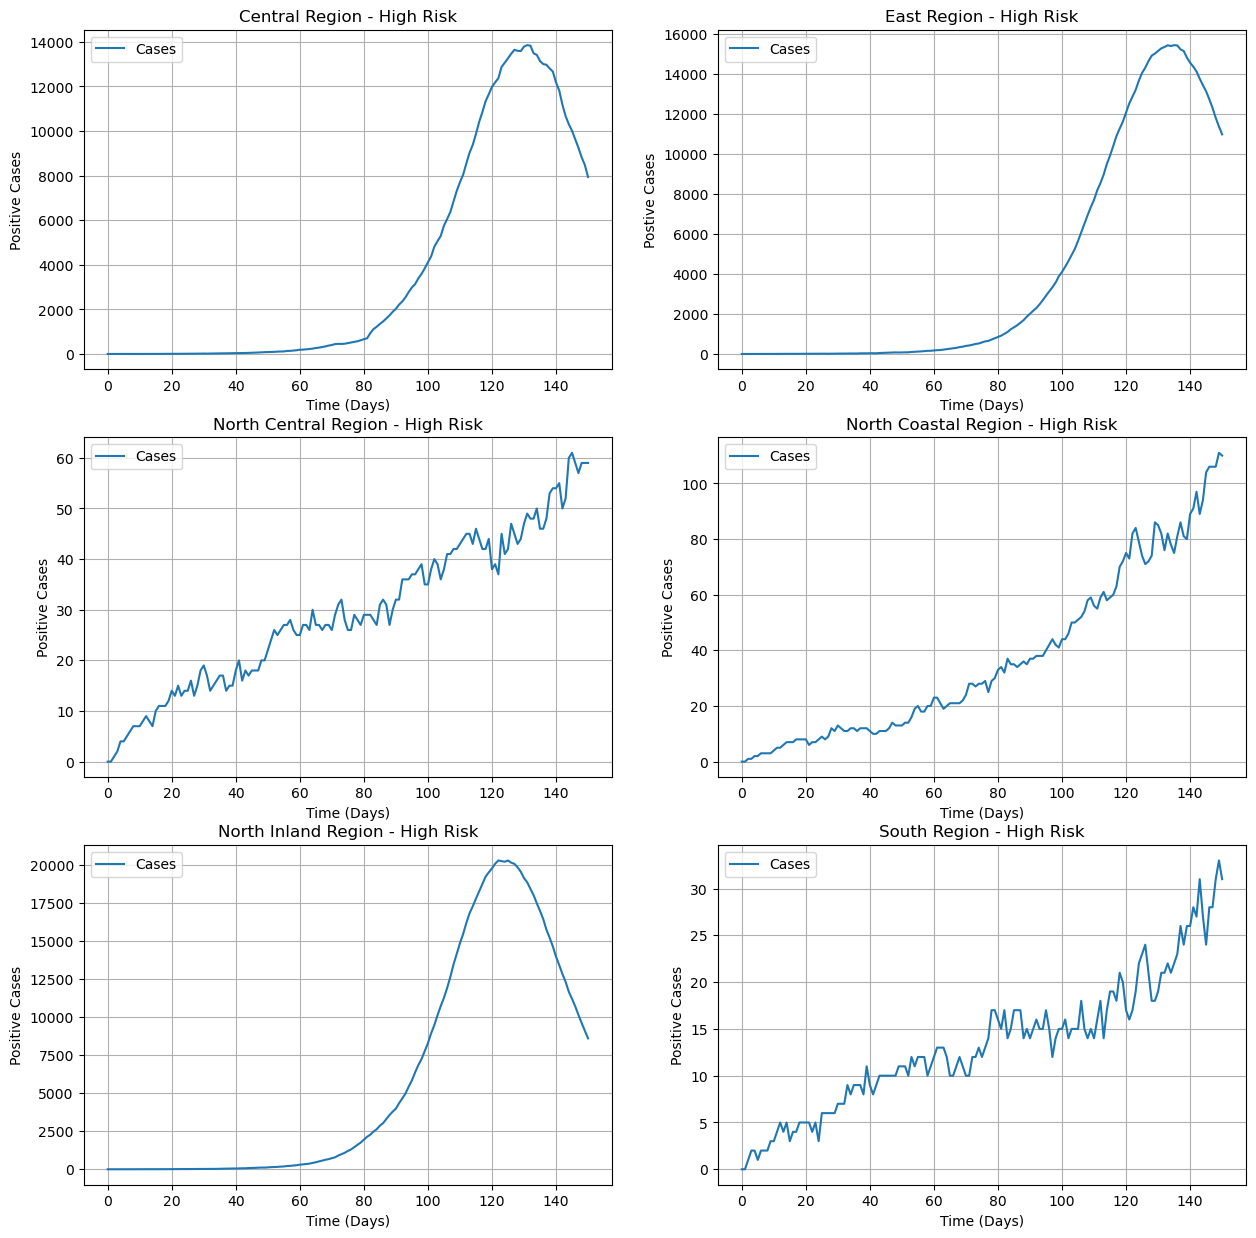

In [30]:
# Plot the simulated cases
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15)) # create subplot to include every region in one figure

ax1.plot(time[:-1], central_high_v1['I'][central_lsqs_min.index[0]][:-1], label='Cases')
ax1.legend()
ax1.set_title('Central Region - High Risk')
ax1.set_xlabel('Time (Days)')
ax1.set_ylabel('Positive Cases')
ax1.grid()

ax2.plot(time[:-1], east_high_v1['I'][east_lsqs_min.index[0]][:-1], label='Cases')
ax2.legend()
ax2.set_title('East Region - High Risk')
ax2.set_xlabel('Time (Days)')
ax2.set_ylabel('Postive Cases')
ax2.grid()

ax3.plot(time[:-1], north_central_high_v1['I'][north_central_lsqs_min.index[0]][:-1], label='Cases')
ax3.legend()
ax3.set_title('North Central Region - High Risk')
ax3.set_xlabel('Time (Days)')
ax3.set_ylabel('Positive Cases')
ax3.grid()

ax4.plot(time[:-1], north_coastal_high_v1['I'][north_coastal_lsqs_min.index[0]][:-1], label='Cases')
ax4.legend()
ax4.set_title('North Coastal Region - High Risk')
ax4.set_xlabel('Time (Days)')
ax4.set_ylabel('Positive Cases')
ax4.grid()

ax5.plot(time[:-1], north_inland_high_v1['I'][north_inland_lsqs_min.index[0]][:-1], label='Cases')
ax5.legend()
ax5.set_title('North Inland Region - High Risk')
ax5.set_xlabel('Time (Days)')
ax5.set_ylabel('Positive Cases')
ax5.grid()

ax6.plot(time[:-1], south_high_v1['I'][south_lsqs_min.index[0]][:-1], label='Cases')
ax6.legend()
ax6.set_title('South Region - High Risk')
ax6.set_xlabel('Time (Days)')
ax6.set_ylabel('Positive Cases')
ax6.grid()


In [ ]:
np.sum(south_high_v1['I'][south_lsqs_min.index[0]][:-2])

4468.0

### Low Risk Scenario

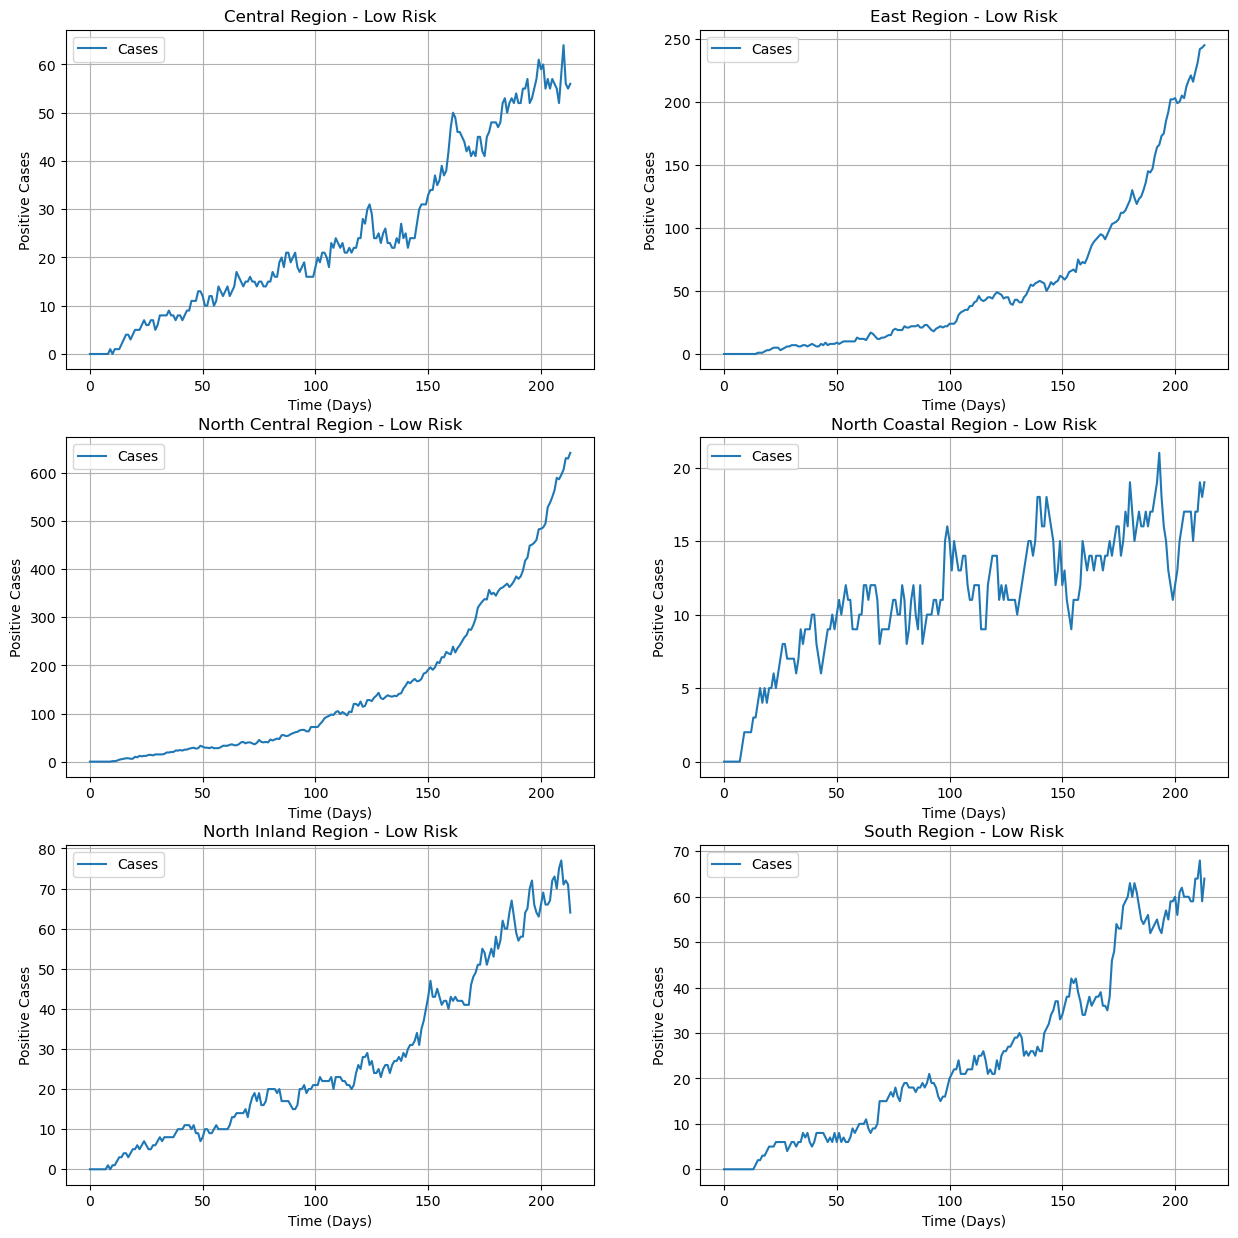

In [ ]:
# Plot the simulated cases
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15)) # create subplot to include every region in one figure

ax1.plot(time[:-2], central_low_v1['I'][central_lsqs_min.index[0]][:-1], label='Cases')
ax1.legend()
ax1.set_title('Central Region - Low Risk')
ax1.set_xlabel('Time (Days)')
ax1.set_ylabel('Positive Cases')
ax1.grid()

ax2.plot(time[:-2], east_low_v1['I'][east_lsqs_min.index[0]][:-1], label='Cases')
ax2.legend()
ax2.set_title('East Region - Low Risk')
ax2.set_xlabel('Time (Days)')
ax2.set_ylabel('Positive Cases')
ax2.grid()

ax3.plot(time[:-2], north_central_low_v1['I'][north_central_lsqs_min.index[0]][:-1], label='Cases')
ax3.legend()
ax3.set_title('North Central Region - Low Risk')
ax3.set_xlabel('Time (Days)')
ax3.set_ylabel('Positive Cases')
ax3.grid()

ax4.plot(time[:-2], north_coastal_low_v1['I'][north_coastal_lsqs_min.index[0]][:-1], label='Cases')
ax4.legend()
ax4.set_title('North Coastal Region - Low Risk')
ax4.set_xlabel('Time (Days)')
ax4.set_ylabel('Positive Cases')
ax4.grid()

ax5.plot(time[:-2], north_inland_low_v1['I'][north_inland_lsqs_min.index[0]][:-1], label='Cases')
ax5.legend()
ax5.set_title('North Inland Region - Low Risk')
ax5.set_xlabel('Time (Days)')
ax5.set_ylabel('Positive Cases')
ax5.grid()

ax6.plot(time[:-2], south_low_v1['I'][south_lsqs_min.index[0]][:-1], label='Cases')
ax6.legend()
ax6.set_title('South Region - Low Risk')
ax6.set_xlabel('Time (Days)')
ax6.set_ylabel('Positive Cases')
ax6.grid()


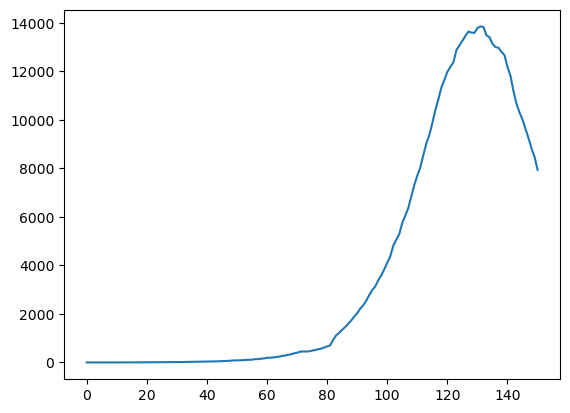

In [31]:
plt.plot(central_high_v1['I'][central_lsqs_min.index[0]][:-1])

### Total Cases

In [32]:
total_central = central_high_v1['I'][central_lsqs_min.index[0]][:-1] + central_low_v1['I'][central_lsqs_min.index[0]][:-1]
total_east = east_high_v1['I'][east_lsqs_min.index[0]][:-1] + east_low_v1['I'][east_lsqs_min.index[0]][:-1]
total_north_central = north_central_high_v1['I'][north_central_lsqs_min.index[0]][:-1] + north_central_low_v1['I'][north_central_lsqs_min.index[0]][:-1]
total_north_coastal = north_coastal_high_v1['I'][north_coastal_lsqs_min.index[0]][:-1] + north_coastal_low_v1['I'][north_coastal_lsqs_min.index[0]][:-1]
total_north_inland = north_inland_high_v1['I'][north_inland_lsqs_min.index[0]][:-1] + north_inland_low_v1['I'][north_inland_lsqs_min.index[0]][:-1]
total_south = south_high_v1['I'][south_lsqs_min.index[0]][:-1] + south_low_v1['I'][south_lsqs_min.index[0]][:-1]

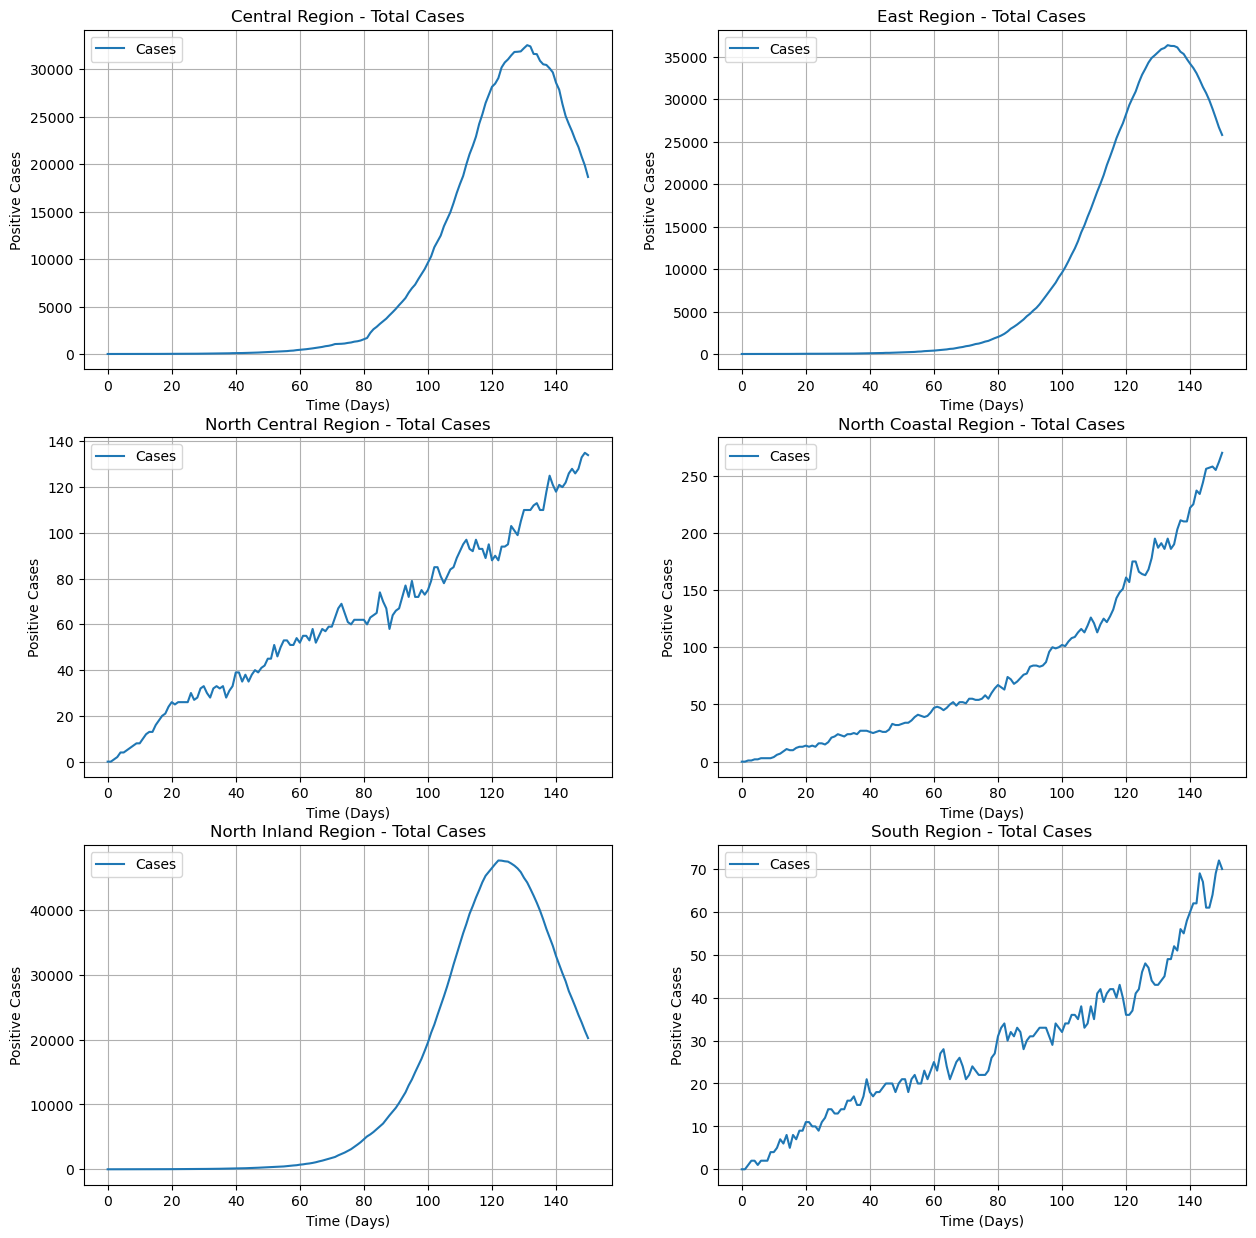

In [34]:
# Plot the simulated cases
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15)) # create subplot to include every region in one figure

ax1.plot(time[:-1], total_central, label='Cases')
ax1.legend()
ax1.set_title('Central Region - Total Cases')
ax1.set_xlabel('Time (Days)')
ax1.set_ylabel('Positive Cases')
ax1.grid()

ax2.plot(time[:-1], total_east, label='Cases')
ax2.legend()
ax2.set_title('East Region - Total Cases')
ax2.set_xlabel('Time (Days)')
ax2.set_ylabel('Positive Cases')
ax2.grid()

ax3.plot(time[:-1], total_north_central, label='Cases')
ax3.legend()
ax3.set_title('North Central Region - Total Cases')
ax3.set_xlabel('Time (Days)')
ax3.set_ylabel('Positive Cases')
ax3.grid()

ax4.plot(time[:-1], total_north_coastal, label='Cases')
ax4.legend()
ax4.set_title('North Coastal Region - Total Cases')
ax4.set_xlabel('Time (Days)')
ax4.set_ylabel('Positive Cases')
ax4.grid()

ax5.plot(time[:-1], total_north_inland, label='Cases')
ax5.legend()
ax5.set_title('North Inland Region - Total Cases')
ax5.set_xlabel('Time (Days)')
ax5.set_ylabel('Positive Cases')
ax5.grid()

ax6.plot(time[:-1], total_south, label='Cases')
ax6.legend()
ax6.set_title('South Region - Total Cases')
ax6.set_xlabel('Time (Days)')
ax6.set_ylabel('Positive Cases')
ax6.grid()


## MC vs the Mobility

In [ ]:
df = pd.read_excel('/Users/kazi0302/Desktop/SDSU/MSCSDS/COVID-19-Modeling-and-Parameter-Fitting/Data/MobilityData.xlsx', sheet_name='Master', header=[0,1])
df.dropna(axis=1, how='all', inplace=True)

# Total population of each region
central_tot = 511660
east_tot = 488330
north_central_tot = 646380
north_coastal_tot = 535219
north_inland_tot = 602000
south_tot = 500076

# Split the data into 6 regions
central = pd.concat([df.iloc[:, 0], df.iloc[:, 3:8]], axis=1)
east = pd.concat([df.iloc[:, 0], df.iloc[:, 8:13]], axis=1)
n_central = pd.concat([df.iloc[:, 0], df.iloc[:, 13:18]], axis=1)
n_coastal = pd.concat([df.iloc[:, 0], df.iloc[:, 18:23]], axis=1)
n_inland = pd.concat([df.iloc[:, 0], df.iloc[:, 23:28]], axis=1)
south = pd.concat([df.iloc[:, 0], df.iloc[:, 28:33]], axis=1)

# Calculate the ratio of people moved from each region to each other region (% converted)
central['Ratio Moved (to East)'] = central['Central', 'East'].apply(lambda x: 100*(x/central_tot))
central['Ratio Moved (to North Central)'] = central['Central', 'North Central'].apply(lambda x: 100*(x/central_tot))
central['Ratio Moved (to North Coastal)'] = central['Central', 'North Coastal'].apply(lambda x: 100*(x/central_tot))
central['Ratio Moved (to North Inland)'] = central['Central', 'North Inland'].apply(lambda x: 100*(x/central_tot))
central['Ratio Moved (to South)'] = central['Central', 'South'].apply(lambda x: 100*(x/central_tot))

east['Ratio Moved (to Central)'] = east['East', 'Central'].apply(lambda x: 100*(x/east_tot))
east['Ratio Moved (to North Central)'] = east['East', 'North Central'].apply(lambda x: 100*(x/east_tot))
east['Ratio Moved (to North Coastal)'] = east['East', 'North Coastal'].apply(lambda x: 100*(x/east_tot))
east['Ratio Moved (to North Inland)'] = east['East', 'North Inland'].apply(lambda x: 100*(x/east_tot))
east['Ratio Moved (to South)'] = east['East', 'South'].apply(lambda x: 100*(x/east_tot))

n_central['Ratio Moved (to Central)'] = n_central['North Central', 'Central'].apply(lambda x: 100*(x/north_central_tot))
n_central['Ratio Moved (to East)'] = n_central['North Central', 'East'].apply(lambda x: 100*(x/north_central_tot))
n_central['Ratio Moved (to North Coastal)'] = n_central['North Central', 'North Coastal'].apply(lambda x: 100*(x/north_central_tot))
n_central['Ratio Moved (to North Inland)'] = n_central['North Central', 'North Inland'].apply(lambda x: 100*(x/north_central_tot))
n_central['Ratio Moved (to South)'] = n_central['North Central', 'South'].apply(lambda x: 100*(x/north_central_tot))

n_coastal['Ratio Moved (to Central)'] = n_coastal['North Coastal', 'Central'].apply(lambda x: 100*(x/north_coastal_tot))
n_coastal['Ratio Moved (to East)'] = n_coastal['North Coastal', 'East'].apply(lambda x: 100*(x/north_coastal_tot))
n_coastal['Ratio Moved (to North Central)'] = n_coastal['North Coastal', 'North Central'].apply(lambda x: 100*(x/north_coastal_tot))
n_coastal['Ratio Moved (to North Inland)'] = n_coastal['North Coastal', 'North Inland'].apply(lambda x: 100*(x/north_coastal_tot))
n_coastal['Ratio Moved (to South)'] = n_coastal['North Coastal', 'South'].apply(lambda x: 100*(x/north_coastal_tot))

n_inland['Ratio Moved (to Central)'] = n_inland['North Inland', 'Central'].apply(lambda x: 100*(x/north_inland_tot))
n_inland['Ratio Moved (to East)'] = n_inland['North Inland', 'East'].apply(lambda x: 100*(x/north_inland_tot))
n_inland['Ratio Moved (to North Central)'] = n_inland['North Inland', 'North Central'].apply(lambda x: 100*(x/north_inland_tot))
n_inland['Ratio Moved (to North Coastal)'] = n_inland['North Inland', 'North Coastal'].apply(lambda x: 100*(x/north_inland_tot))
n_inland['Ratio Moved (to South)'] = n_inland['North Inland', 'South'].apply(lambda x: 100*(x/north_inland_tot))

south['Ratio Moved (to Central)'] = south['South', 'Central'].apply(lambda x: 100*(x/south_tot))
south['Ratio Moved (to East)'] = south['South', 'East'].apply(lambda x: 100*(x/south_tot))
south['Ratio Moved (to North Central)'] = south['South', 'North Central'].apply(lambda x: 100*(x/south_tot))
south['Ratio Moved (to North Coastal)'] = south['South', 'North Coastal'].apply(lambda x: 100*(x/south_tot))
south['Ratio Moved (to North Inland)'] = south['South', 'North Inland'].apply(lambda x: 100*(x/south_tot))

In [ ]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

# ax1.set_title('Central')
# ax1.plot(time[:-2], total_central, label='Cases')
# ax1.legend()
# ax1.set_xlabel('Time')
# ax1.set_ylabel('Cases')
# ax1.grid()

# ax2.set_title('From Central')
# ax2.plot(df['Date', 'Date'], df['Central', 'East'], label = 'To East', color = 'r')
# ax2.plot(df['Date', 'Date'], df['Central', 'North Central'], label = 'To North Central', color = 'm')
# ax2.plot(df['Date', 'Date'], df['Central', 'North Coastal'], label = 'To North Coastal', color = 'b')
# ax2.plot(df['Date', 'Date'], df['Central', 'North Inland'], label = 'To North Inland', color = 'tab:orange')
# ax2.plot(df['Date', 'Date'], df['Central', 'South'], label = 'To South', color = 'tab:gray')
# ax2.legend(loc='upper right', fontsize='9')
# ax2.grid()

# ax3.set_title('Central')
# ax3.plot(time[:-2], total_central, label='Cases')
# ax3.legend()
# ax3.set_xlabel('Time')
# ax3.set_ylabel('Cases')
# ax3.grid()

# ax4.set_title('To Central')
# ax4.plot(df['Date', 'Date'], df['East', 'Central'], label = 'From East', color = 'r')
# ax4.plot(df['Date', 'Date'], df['North Central', 'Central'], label = 'From North Central', color = 'm')
# ax4.plot(df['Date', 'Date'], df['North Coastal', 'Central'], label = 'From North Coastal', color = 'b')
# ax4.plot(df['Date', 'Date'], df['North Inland', 'Central'], label = 'From North Inland', color = 'tab:orange')
# ax4.plot(df['Date', 'Date'], df['South', 'Central'], label = 'From South', color = 'tab:gray')
# ax4.legend(loc='upper right', fontsize='9')
# ax4.grid()

In [ ]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

# ax1.set_title('East')
# ax1.plot(time[:-2], total_east, label='Cases')
# ax1.legend()
# ax1.set_xlabel('Time')
# ax1.set_ylabel('Cases')
# ax1.grid()

# ax2.set_title('From East')
# ax2.plot(df['Date', 'Date'], df['East', 'Central'], label = 'To Central', color = 'r')
# ax2.plot(df['Date', 'Date'], df['East', 'North Central'], label = 'To North Central', color = 'm')
# ax2.plot(df['Date', 'Date'], df['East', 'North Coastal'], label = 'To North Coastal', color = 'b')
# ax2.plot(df['Date', 'Date'], df['East', 'North Inland'], label = 'To North Inland', color = 'tab:orange')
# ax2.plot(df['Date', 'Date'], df['East', 'South'], label = 'To South', color = 'tab:gray')
# ax2.legend(loc='upper right', fontsize='9')
# ax2.grid()

# ax3.set_title('East')
# ax3.plot(time[:-2], total_east, label='Cases')
# ax3.legend()
# ax3.set_xlabel('Time')
# ax3.set_ylabel('Cases')
# ax3.grid()

# ax4.set_title('To East')
# ax4.plot(df['Date', 'Date'], df['Central', 'East'], label = 'From Central', color = 'r')
# ax4.plot(df['Date', 'Date'], df['North Central', 'East'], label = 'From North Central', color = 'm')
# ax4.plot(df['Date', 'Date'], df['North Coastal', 'East'], label = 'From North Coastal', color = 'b')
# ax4.plot(df['Date', 'Date'], df['North Inland', 'East'], label = 'From North Inland', color = 'tab:orange')
# ax4.plot(df['Date', 'Date'], df['South', 'East'], label = 'From South', color = 'tab:gray')
# ax4.legend(loc='upper right', fontsize='9')
# ax4.grid()

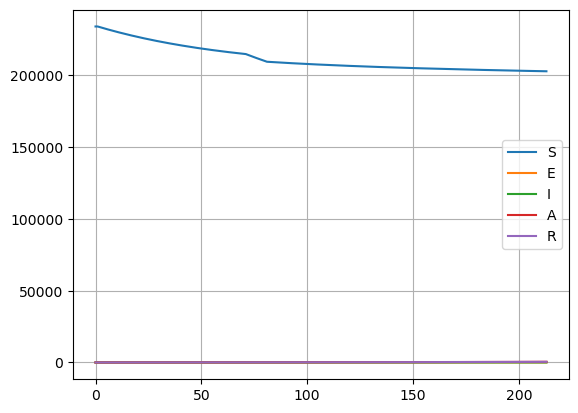

In [ ]:
plt.plot(time[:-2], central_high_v1['S'][central_lsqs_min.index[0]][:-1], label='S')
plt.plot(time[:-2], central_high_v1['E'][central_lsqs_min.index[0]][:-1], label='E')
plt.plot(time[:-2], central_high_v1['I'][central_lsqs_min.index[0]][:-1], label='I')
plt.plot(time[:-2], central_high_v1['A'][central_lsqs_min.index[0]][:-1], label='A')
plt.plot(time[:-2], central_high_v1['R'][central_lsqs_min.index[0]][:-1], label='R')
plt.legend()
plt.grid()
plt.show()

In [ ]:
np.sum(central_high_v1['I'][central_lsqs_min.index[0]][1:-2])

4142.0

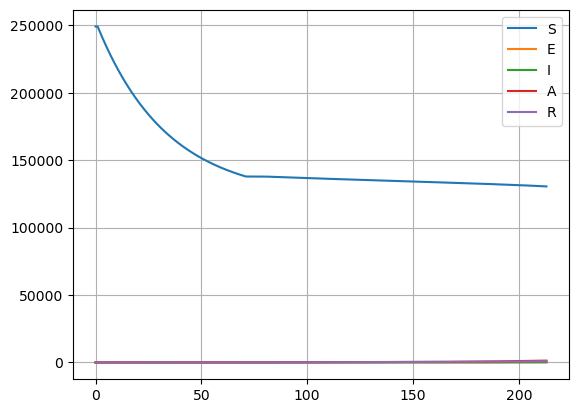

In [ ]:
plt.plot(time[:-2], east_high_v1['S'][east_lsqs_min.index[0]][:-1], label='S')
plt.plot(time[:-2], east_high_v1['E'][east_lsqs_min.index[0]][:-1], label='E')
plt.plot(time[:-2], east_high_v1['I'][east_lsqs_min.index[0]][:-1], label='I')
plt.plot(time[:-2], east_high_v1['A'][east_lsqs_min.index[0]][:-1], label='A')
plt.plot(time[:-2], east_high_v1['R'][east_lsqs_min.index[0]][:-1], label='R')
plt.legend()
plt.grid()
plt.show()

In [ ]:
np.sum(east_high_v1['I'][east_lsqs_min.index[0]][:-2])

8737.0

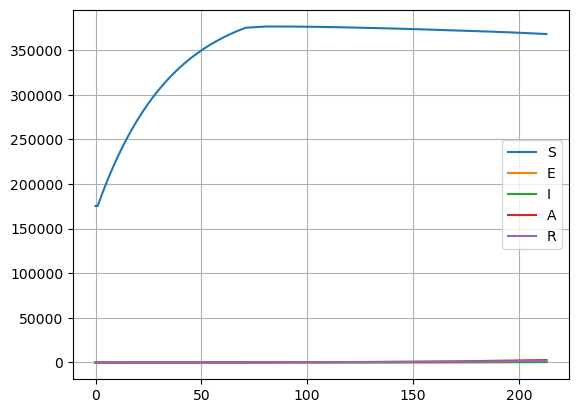

In [ ]:
plt.plot(time[:-2], north_central_high_v1['S'][north_central_lsqs_min.index[0]][:-1], label='S')
plt.plot(time[:-2], north_central_high_v1['E'][north_central_lsqs_min.index[0]][:-1], label='E')
plt.plot(time[:-2], north_central_high_v1['I'][north_central_lsqs_min.index[0]][:-1], label='I')
plt.plot(time[:-2], north_central_high_v1['A'][north_central_lsqs_min.index[0]][:-1], label='A')
plt.plot(time[:-2], north_central_high_v1['R'][north_central_lsqs_min.index[0]][:-1], label='R')
plt.legend()
plt.grid()
plt.show()

In [ ]:
np.sum(north_central_high_v1['I'][north_central_lsqs_min.index[0]][:-1])

24486.0

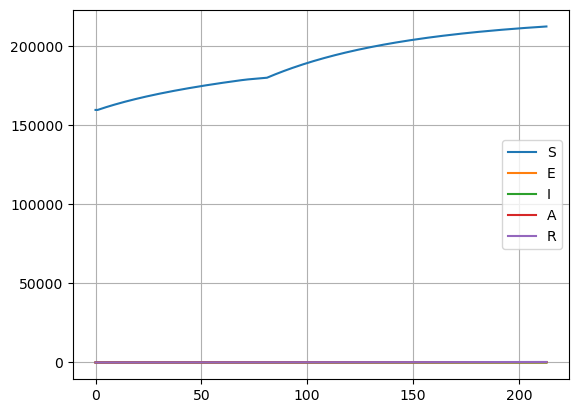

In [ ]:
plt.plot(time[:-2], north_coastal_high_v1['S'][north_coastal_lsqs_min.index[0]][:-1], label='S')
plt.plot(time[:-2], north_coastal_high_v1['E'][north_coastal_lsqs_min.index[0]][:-1], label='E')
plt.plot(time[:-2], north_coastal_high_v1['I'][north_coastal_lsqs_min.index[0]][:-1], label='I')
plt.plot(time[:-2], north_coastal_high_v1['A'][north_coastal_lsqs_min.index[0]][:-1], label='A')
plt.plot(time[:-2], north_coastal_high_v1['R'][north_coastal_lsqs_min.index[0]][:-1], label='R')
plt.legend()
plt.grid()
plt.show()

In [ ]:
np.sum(north_coastal_high_v1['I'][north_coastal_lsqs_min.index[0]][:-1])

2487.0

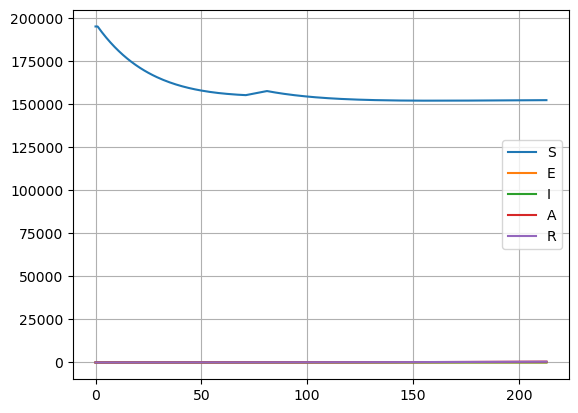

In [ ]:
plt.plot(time[:-2], north_inland_high_v1['S'][north_inland_lsqs_min.index[0]][:-1], label='S')
plt.plot(time[:-2], north_inland_high_v1['E'][north_inland_lsqs_min.index[0]][:-1], label='E')
plt.plot(time[:-2], north_inland_high_v1['I'][north_inland_lsqs_min.index[0]][:-1], label='I')
plt.plot(time[:-2], north_inland_high_v1['A'][north_inland_lsqs_min.index[0]][:-1], label='A')
plt.plot(time[:-2], north_inland_high_v1['R'][north_inland_lsqs_min.index[0]][:-1], label='R')
plt.legend()
plt.grid()
plt.show()

In [ ]:
np.sum(north_inland_high_v1['I'][north_inland_lsqs_min.index[0]][:-1])

4528.0

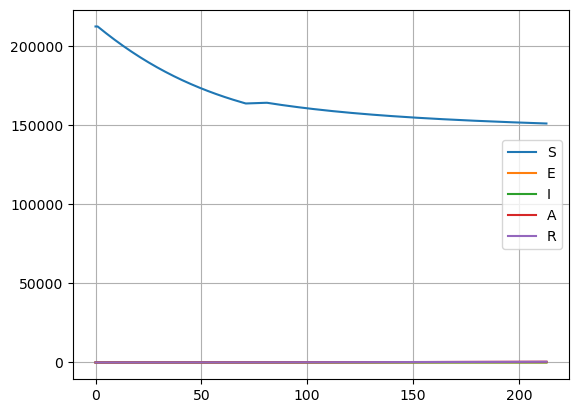

In [ ]:
plt.plot(time[:-2], south_high_v1['S'][south_lsqs_min.index[0]][:-1], label='S')
plt.plot(time[:-2], south_high_v1['E'][south_lsqs_min.index[0]][:-1], label='E')
plt.plot(time[:-2], south_high_v1['I'][south_lsqs_min.index[0]][:-1], label='I')
plt.plot(time[:-2], south_high_v1['A'][south_lsqs_min.index[0]][:-1], label='A')
plt.plot(time[:-2], south_high_v1['R'][south_lsqs_min.index[0]][:-1], label='R')
plt.legend()
plt.grid()
plt.show()

In [ ]:
np.sum(south_high_v1['I'][south_lsqs_min.index[0]][:-1])

4522.0

In [ ]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

# ax1.set_title('North Central')
# ax1.plot(time[:-2], total_north_central, label='Cases')
# ax1.legend()
# ax1.set_xlabel('Time')
# ax1.set_ylabel('Cases')
# ax1.grid()

# ax2.set_title('From North Central')
# ax2.plot(df['Date', 'Date'], df['North Central', 'Central'], label = 'To Central', color = 'r')
# ax2.plot(df['Date', 'Date'], df['North Central', 'East'], label = 'To East', color = 'm')
# ax2.plot(df['Date', 'Date'], df['North Central', 'North Coastal'], label = 'To North Coastal', color = 'b')
# ax2.plot(df['Date', 'Date'], df['North Central', 'North Inland'], label = 'To North Inland', color = 'tab:orange')
# ax2.plot(df['Date', 'Date'], df['North Central', 'South'], label = 'To South', color = 'tab:gray')
# ax2.legend(loc='upper right', fontsize='9')
# ax2.grid()

# ax3.set_title('North Central')
# ax3.plot(time[:-2], total_north_central, label='Cases')
# ax3.legend()
# ax3.set_xlabel('Time')
# ax3.set_ylabel('Cases')
# ax3.grid()

# ax4.set_title('To North Central')
# ax4.plot(df['Date', 'Date'], df['Central', 'North Central'], label = 'From Central', color = 'r')
# ax4.plot(df['Date', 'Date'], df['East', 'North Central'], label = 'From East', color = 'm')
# ax4.plot(df['Date', 'Date'], df['North Coastal', 'North Central'], label = 'From North Coastal', color = 'b')
# ax4.plot(df['Date', 'Date'], df['North Inland', 'North Central'], label = 'From North Inland', color = 'tab:orange')
# ax4.plot(df['Date', 'Date'], df['South', 'North Central'], label = 'From South', color = 'tab:gray')
# ax4.legend(loc='upper right', fontsize='9')
# ax4.grid()

In [ ]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

# ax1.set_title('North Coastal')
# ax1.plot(time[:-2], total_north_coastal, label='Cases')
# ax1.legend()
# ax1.set_xlabel('Time')
# ax1.set_ylabel('Cases')
# ax1.grid()

# ax2.set_title('From North Coastal')
# ax2.plot(df['Date', 'Date'], df['North Coastal', 'Central'], label = 'To Central', color = 'r')
# ax2.plot(df['Date', 'Date'], df['North Coastal', 'East'], label = 'To East', color = 'm')
# ax2.plot(df['Date', 'Date'], df['North Coastal', 'North Central'], label = 'To North Central', color = 'b')
# ax2.plot(df['Date', 'Date'], df['North Coastal', 'North Inland'], label = 'To North Inland', color = 'tab:orange')
# ax2.plot(df['Date', 'Date'], df['North Coastal', 'South'], label = 'To South', color = 'tab:gray')
# ax2.legend(loc='upper right', fontsize='9')
# ax2.grid()

# ax3.set_title('North Coastal')
# ax3.plot(time[:-2], total_north_coastal, label='Cases')
# ax3.legend()
# ax3.set_xlabel('Time')
# ax3.set_ylabel('Cases')
# ax3.grid()

# ax4.set_title('To North Coastal')
# ax4.plot(df['Date', 'Date'], df['Central', 'North Coastal'], label = 'From Central', color = 'r')
# ax4.plot(df['Date', 'Date'], df['East', 'North Coastal'], label = 'From East', color = 'm')
# ax4.plot(df['Date', 'Date'], df['North Central', 'North Coastal'], label = 'From North Central', color = 'b')
# ax4.plot(df['Date', 'Date'], df['North Inland', 'North Coastal'], label = 'From North Inland', color = 'tab:orange')
# ax4.plot(df['Date', 'Date'], df['South', 'North Coastal'], label = 'From South', color = 'tab:gray')
# ax4.legend(loc='upper right', fontsize='9')
# ax4.grid()

In [ ]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

# ax1.set_title('North Inland')
# ax1.plot(time[:-2], total_north_inland, label='Cases')
# ax1.legend()
# ax1.set_xlabel('Time')
# ax1.set_ylabel('Cases')
# ax1.grid()

# ax2.set_title('From North Inland')
# ax2.plot(df['Date', 'Date'], df['North Inland', 'Central'], label = 'To Central', color = 'r')
# ax2.plot(df['Date', 'Date'], df['North Inland', 'East'], label = 'To East', color = 'm')
# ax2.plot(df['Date', 'Date'], df['North Inland', 'North Central'], label = 'To North Central', color = 'b')
# ax2.plot(df['Date', 'Date'], df['North Inland', 'North Coastal'], label = 'To North Coastal', color = 'tab:orange')
# ax2.plot(df['Date', 'Date'], df['North Inland', 'South'], label = 'To South', color = 'tab:gray')
# ax2.legend(loc='upper right', fontsize='9')
# ax2.grid()

# ax3.set_title('North Inland')
# ax3.plot(time[:-2], total_north_inland, label='Cases')
# ax3.legend()
# ax3.set_xlabel('Time')
# ax3.set_ylabel('Cases')
# ax3.grid()

# ax4.set_title('To North Inland')
# ax4.plot(df['Date', 'Date'], df['Central', 'North Inland'], label = 'From Central', color = 'r')
# ax4.plot(df['Date', 'Date'], df['East', 'North Inland'], label = 'From East', color = 'm')
# ax4.plot(df['Date', 'Date'], df['North Central', 'North Inland'], label = 'From North Central', color = 'b')
# ax4.plot(df['Date', 'Date'], df['North Coastal', 'North Inland'], label = 'From North Coastal', color = 'tab:orange')
# ax4.plot(df['Date', 'Date'], df['South', 'North Inland'], label = 'From South', color = 'tab:gray')
# ax4.legend(loc='upper right', fontsize='9')
# ax4.grid()

In [ ]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

# ax1.set_title('South')
# ax1.plot(time[:-2], total_south, label='Cases')
# ax1.legend()
# ax1.set_xlabel('Time')
# ax1.set_ylabel('Cases')
# ax1.grid()

# ax2.set_title('From South')
# ax2.plot(df['Date', 'Date'], df['South', 'Central'], label = 'To Central', color = 'r')
# ax2.plot(df['Date', 'Date'], df['South', 'East'], label = 'To East', color = 'm')
# ax2.plot(df['Date', 'Date'], df['South', 'North Central'], label = 'To North Central', color = 'b')
# ax2.plot(df['Date', 'Date'], df['South', 'North Coastal'], label = 'To North Coastal', color = 'tab:orange')
# ax2.plot(df['Date', 'Date'], df['South', 'North Inland'], label = 'To North Inland', color = 'tab:gray')
# ax2.legend(loc='upper right', fontsize='9')
# ax2.grid()

# ax3.set_title('South')
# ax3.plot(time[:-2], total_south, label='Cases')
# ax3.legend()
# ax3.set_xlabel('Time')
# ax3.set_ylabel('Cases')
# ax3.grid()

# ax4.set_title('To South')
# ax4.plot(df['Date', 'Date'], df['Central', 'South'], label = 'From Central', color = 'r')
# ax4.plot(df['Date', 'Date'], df['East', 'South'], label = 'From East', color = 'm')
# ax4.plot(df['Date', 'Date'], df['North Central', 'South'], label = 'From North Central', color = 'b')
# ax4.plot(df['Date', 'Date'], df['North Coastal', 'South'], label = 'From North Coastal', color = 'tab:orange')
# ax4.plot(df['Date', 'Date'], df['North Inland', 'South'], label = 'From North Inland', color = 'tab:gray')
# ax4.legend(loc='upper right', fontsize='9')
# ax4.grid()